# Import et fonctions utilitaires

In [1]:
from PC import PC
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bn_vs_bn
import time
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import io

#Fonction qui permet la création de tous les BN possibles étant donné un graphe essentiel
def get_approxBN(bn,AlgoPC:PC):
    """
    retourne tous les BN possible à partir d'un graphe essentiel
    Parameters
    ----------
    AlgoPC : PC
        l'objet associé à l'apprentissage
    bn : pyAgrum.BayesNet
        le bn qui a généré le CSV (pour des raisons de nommages de noeuds)
    Returns
    -------
    liste de pyAgrum.BayesNet ou un pyAgrum.BayesNet
        le/les BN associé
    """
    nb_BN=2**len(AlgoPC.G.edges()) #le nombre de BN possibles dépend du nombre d'arretes dans la classe d'équivalence de Markov
    bn_approx_base=gum.BayesNet('bn_approx_base')
    allApproxBn=[]
    for nodeID in AlgoPC.G.nodes():
        bn_approx_base.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        try :
            bn_approx_base.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            print("CYCLE DANS UN DAG !")
            # gnb.sideBySide(GPhase1,GPhase21,GPhase2)
            # print(AlgoPC.verbose)
            raise
            return []
    if(len(AlgoPC.G.edges())!=0): #Si G a des arêtes
        allApproxBn=[gum.BayesNet(bn_approx_base) for _ in range(nb_BN)]
        permutations=[]
        for node1,node2 in AlgoPC.G.edges():
            permutations+=list(itertools.permutations((node1,node2))) 
        combinations=list(itertools.combinations(permutations,len(AlgoPC.G.edges())))#On cherche toutes les combinaisons d'arcs que l'on peut mettre
        l=[]
        for comb in combinations:
            hasRemoved=False
            for i in range(0,len(comb)-1):
                for j in range(i+1,len(comb)):
                    if( set(comb[i])==set(comb[j])):
                        l.append(comb)
                        hasRemoved=True
                        break
                if(hasRemoved):
                    break
        for comb in l:
            combinations.remove(comb)
        for (bn_i,comb) in zip(allApproxBn,combinations):
            for node1,node2 in comb:
                try:
                    if(not bn_i.existsArc(bn.variable(node1).name(),bn.variable(node2).name())):
                        bn_i.addArc(bn.variable(node1).name(),bn.variable(node2).name())
                except:
                    if(not bn_i.existsArc(bn.variable(node2).name(),bn.variable(node1).name())):
                        bn_i.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    else : #Si G est un DAG
        allApproxBn.append(bn_approx_base)
    return allApproxBn
#Fonction qui permet la création d'un des BN possibles étant donné un graphe essentiel
def getOneApproxBN(bn,AlgoPC:PC):
    """Retour un BN possible à partir d'un graphe essentiel

    Parameters
    ----------
    AlgoPC : PC
        l'objet associé à l'apprentissage
    bn : pyAgrum.BayesNet
        le bn qui a généré le CSV (pour des raisons de nommages de noeuds)
    Returns
    -------
    pyAgrum.BayesNet 
        un BN possible du graphe essentiel
    """    
    bn_approx=gum.BayesNet('bn_approx_base')
    for nodeID in AlgoPC.G.nodes():
        bn_approx.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
    for node1,node2 in AlgoPC.G.edges():
        try:
            if(not bn_approx.existsArc(bn.variable(node1).name(),bn.variable(node2).name())):
                bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            if(not bn_approx.existsArc(bn.variable(node2).name(),bn.variable(node1).name())):
                bn_approx.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    return bn_approx
#Générer un BN aléatoire
def testTempsExec_enFonction_nbNoeuds_2(Algo1,Algo2):
    """Fonction qui test le temps d'exécution en fonction du nombre de noeuds d'un BN.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester
    On test 100 fois pour chaque nb_noeuds (nombre de noeuds) dans [5,8,10,12,15]
    pour 5000 particules avec un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    On calcule aussi la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester

    Returns
    -------
    list de ints et floats
        listes de valeurs qui permettent de mettre sous de forme de graphe les résultats
    """    
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    criteres_all2=[]
    list_nb_nodes=[5,8,10,12,15,20]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            criteres=dict()
            criteres2=dict()
            _,duration,_=Algo1(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            _,duration2,_=Algo2(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            criteres_all.append(criteres)
            criteres_all2.append(criteres2)
            criteres["duration"]=duration
            criteres["n_nodes"]=n_nodes
            criteres2["duration"]=duration2
            criteres2["n_nodes"]=n_nodes
    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    bny2=[criteres["duration"] for criteres in criteres_all2]
    list_moy_selon_nb_nodes=[]
    list_moy_selon_nb_nodes2=[]
    for n in list_nb_nodes:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["n_nodes"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_nodes.append(moy/i)
        moy2=0
        i2=0
        for criteres2 in criteres_all2:
            if(criteres2["n_nodes"]==n):
                moy2+=criteres2["duration"]
                i2+=1
        list_moy_selon_nb_nodes2.append(moy2/i2)
    return bnx,bny,bny2,list_nb_nodes,list_moy_selon_nb_nodes,list_moy_selon_nb_nodes2
def plot_testTempsExec_enFonction_nbNoeuds_bis(bnx,bny1,bny2,list_nb_nodes,list_moy_selon_nb_nodes1,list_moy_selon_nb_nodes2,nameAlgo1:str,nameAlgo2:str):
    """Fonction qui permet de visualiser sous forme de graphe les résultats du test "testTempsExec_enFonction_nbNoeuds"

    Parameters
    ----------
    bnx : list
        valeurs des abscisses (en nombre de noeuds)
    bny : list
        liste de listes de valeurs des ordonnées (en secondes) pour deux algo différents
    list_nb_nodes : list
        liste des nombres de noeuds que l'on a testé
    list_moy_selon_nb_nodes : list
        listes des moyennes des temps d'exécutions pour chaque nombre nb_noeuds de noeuds que l'on a testé
    nameAlgo1 : str
        nom de l'algo avec les données bny1
    nameAlgo1 : str
        nom de l'algo avec les données bny1
    """    
    #Plot nombre particules/ Temps en s d'execution
    scat1=plt.scatter(bnx,bny1,label=f"temps d'execution de {nameAlgo1}",s=3,c='r')
    scat2=plt.scatter(bnx,bny2,label=f"temps d'execution de {nameAlgo2}",s=3,c='b')
    line=plt.plot(list_nb_nodes,list_moy_selon_nb_nodes1,c='r',label=f"temps d'execution moyen de {nameAlgo1}")
    line2=plt.plot(list_nb_nodes,list_moy_selon_nb_nodes2,c='b',label=f"temps d'execution moyen de {nameAlgo2}")
    plt.title("Temps d'éxécution en fonction du nombre de noeuds")
    plt.xlabel("Nombre de noeuds")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()
def genRandomBN(n=20000,n_nodes=5, n_arcs=8, n_modmax=4,name_out="test.csv"):
    """Générateur aléatoire de BN

    Parameters
    ----------
    n : int, optional
        nombre de particules à générer dans le CSV, by default 20000
    n_nodes : int, optional
        nombre de noeuds, by default 5
    n_arcs : int, optional
        nombre d'arcs, by default 8
    n_modmax : int, optional
        nombre de modalités maximum d'un noeud, by default 4
    name_out : str, optional
        le nom du CSV crée, by default "test.csv"

    Returns
    -------
    pyAgrum.BayesNet
        le bn généré
    """    
    generator=gum.BNGenerator()
    bn=generator.generate(n_nodes, n_arcs, n_modmax)
    gum.generateCSV(bn,name_out, n, show_progress=False, with_labels=False)
    return bn
def testTempsExec_enFonction_nbNoeuds(Algo):
    """Fonction qui test le temps d'exécution en fonction du nombre de noeuds d'un BN.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester
    On test 100 fois pour chaque nb_noeuds (nombre de noeuds) dans [5,8,10,12,15]
    pour 5000 particules avec un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    On calcule aussi la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester

    Returns
    -------
    list de ints et floats
        listes de valeurs qui permettent de mettre sous de forme de graphe les résultats
    """    
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    list_nb_nodes=[5,8,10,12,15]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            criteres=dict()
            _,duration,_=Algo(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            criteres_all.append(criteres)
            criteres["duration"]=duration
            criteres["n_nodes"]=n_nodes
    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    list_moy_selon_nb_nodes=[]
    for n in list_nb_nodes:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["n_nodes"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_nodes.append(moy/i)
    return bnx,bny,list_nb_nodes,list_moy_selon_nb_nodes
def tests_bn_vs_bn_enFontion_nbParticules2(Algo,Algo2,isSkeleton=False):
    """Fonction qui test 100 fois pour différents nombre de particules (dans [1000,5000,10000,15000,20000]) les critères
    hamming, structural hamming, precision, recall,fscore et dist2opt avec un nombre de noeuds aléatoire dans [5,10] et un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester.
    On calcule aussi, pour chaque critère, la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Le nombre 
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester
    Returns
    -------
    les listes des résultats du test
        liste de ints ou de floats
    """
    nb_apprentissage_par_n_particules=100
    criteres_all=[]
    criteres_all2=[]
    list_nb_particules=[1000,5000,10000,15000,20000]
    for n in list_nb_particules:
        n_nodes=random.randint(5,10)
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_particules):
            oneBNApprox,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            oneBNApprox2,_,_=Algo2(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            # if len(bn_approx_all)==0:
            #     continue
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBNApprox)
            comparator2=bn_vs_bn.GraphicalBNComparator(bn_original,oneBNApprox2)
            if isSkeleton:
                criteres=comparator.skeletonScores()
            else: 
                criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["nb_particules"]=n
            criteres_all.append(criteres)

            criteres2=comparator2.scores()
            criteres2.update(comparator2.hamming())
            criteres2["nb_particules"]=n
            criteres_all2.append(criteres2)

    bnx=[criteres["nb_particules"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    bny_hamming2=[criteres["hamming"] for criteres in criteres_all2]
    bny_StructuralHamming2=[criteres["structural hamming"] for criteres in criteres_all2]
    bny_precision2=[criteres["precision"] for criteres in criteres_all2]
    bny_recall2=[criteres["recall"] for criteres in criteres_all2]
    bny_fscore2=[criteres["fscore"] for criteres in criteres_all2]
    bny_dist2opt2=[criteres["dist2opt"] for criteres in criteres_all2]

    moy_all=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_particules=[]
        for n in list_nb_particules:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["nb_particules"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_particules.append(moy/i)
        moy_all[name]=list_moy_selon_nb_particules
    
    moy_all2=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_particules2=[]
        for n in list_nb_particules:
            moy=0
            i=0
            for criteres in criteres_all2:
                if(criteres["nb_particules"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_particules2.append(moy/i)
        moy_all2[name]=list_moy_selon_nb_particules2
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules,bny_hamming2,bny_StructuralHamming2,bny_precision2,bny_recall2,bny_fscore2,bny_dist2opt2,moy_all2
def plot_tests_bn_vs_bn_enFontion_nbParticules2(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules,bny_hamming2,bny_StructuralHamming2,bny_precision2,bny_recall2,bny_fscore2,bny_dist2opt2,moy_all2,nameAlgo1:str,nameAlgo2:str):
    """Fonction qui permet de visualiser sous forme de graphe le résultat du test "tests_bn_vs_bn_enFontion_nbParticules"

    Parameters
    ----------
    bnx : list
        abscisses des graphes (nombre de particules)
    bny_hamming : list
        résultats du hamming
    bny_StructuralHamming : list
        résultats du structual hamming
    bny_precision : list
        résultats de précision
    bny_recall : list
        résultats de recall
    bny_fscore : list
        résultats de fscore
    bny_dist2opt : list
        résultats de dist2opt
    moy_all : list
        moyennes des 100 éxécutions pour chaque nombre de particules, pour chaque critère
    list_nb_nodes : list
        la liste des nombres de particules pour lesquels on a testé
    """
    print(f"Rouge = {nameAlgo1} | Bleu = {nameAlgo2}")
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming"+f" de {nameAlgo1}",s=3,c='r')
    f1_axes[0][0].scatter(bnx,bny_hamming2,label="Hamming"+f" de {nameAlgo2}",s=3,c='b')
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_particules,moy_all["hamming"],c='r',label="Hamming moyen"+f" de {nameAlgo1}")
    f1_axes[0][0].plot(list_nb_particules,moy_all2["hamming"],c='b',label="Hamming moyen"+f" de {nameAlgo2}")
    f1_axes[0][0].set_xlabel("nb de particules")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,c='r',label="Structural Hamming"+f" de {nameAlgo1}",s=3)
    f1_axes[0][1].scatter(bnx,bny_StructuralHamming2,c='b',label="Structural Hamming"+f" de {nameAlgo2}",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_particules,moy_all["structural hamming"],c='r',label="Structural Hamming moyen"+f" de {nameAlgo1}")
    f1_axes[0][1].plot(list_nb_particules,moy_all2["structural hamming"],c='b',label="Structural Hamming moyen"+f" de {nameAlgo2}")
    f1_axes[0][1].set_xlabel("nb de particules")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,c='r',label="dist2opt"+f" de {nameAlgo1}",s=3)
    f1_axes[0][2].scatter(bnx,bny_dist2opt2,c='b',label="dist2opt"+f" de {nameAlgo2}",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_particules,moy_all["dist2opt"],c='r',label="dist2opt moyen"+f" de {nameAlgo1}")
    f1_axes[0][2].plot(list_nb_particules,moy_all2["dist2opt"],c='b',label="dist2opt moyen"+f" de {nameAlgo2}")
    f1_axes[0][2].set_xlabel("nb de particules")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,c='r',label="fscore"+f" de {nameAlgo1}",s=3)
    f1_axes[1][0].scatter(bnx,bny_fscore2,c='b',label="fscore"+f" de {nameAlgo2}",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_particules,moy_all["fscore"],c='r',label="fscore moyen"+f" de {nameAlgo1}")
    f1_axes[1][0].plot(list_nb_particules,moy_all2["fscore"],c='b',label="fscore moyen"+f" de {nameAlgo2}")
    f1_axes[1][0].set_xlabel("nb de particules")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,c='r',label="precision"+f" de {nameAlgo1}",s=3)
    f1_axes[1][1].scatter(bnx,bny_precision2,c='b',label="precision"+f" de {nameAlgo2}",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_particules,moy_all["precision"],c='r',label="precision moyen"+f" de {nameAlgo1}")
    f1_axes[1][1].plot(list_nb_particules,moy_all2["precision"],c='b',label="precision moyen"+f" de {nameAlgo2}")
    f1_axes[1][1].set_xlabel("nb de particules")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,c='r',label="recall"+f" de {nameAlgo1}",s=3)
    f1_axes[1][2].scatter(bnx,bny_recall2,c='b',label="recall"+f" de {nameAlgo2}",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_particules,moy_all["recall"],c='r',label="recall moyen"+f" de {nameAlgo1}")
    f1_axes[1][2].plot(list_nb_particules,moy_all2["recall"],c='b',label="recall moyen"+f" de {nameAlgo2}")
    f1_axes[1][2].set_xlabel("nb de particules")
    f1_axes[1][2].set_ylabel("recall")
    fig1.set_figheight(30)
    fig1.set_figwidth(30)
    plt.show()

def testTempsExec_EnFonction_NbParticules2(Algo,Algo2): 
    """Fonction qui test le temps d'exécution en fonction du nombre de particules d'un BN.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester
    On teste 100 fois pour chaque n (nombre de particules, [1000,5000,10000,15000,20000]) avec un nombre de noeuds qui
    varie entre [5,10] et un nombre d'arc égal à 1,25 fois le nombre de noeuds
    On calcule aussi la moyenne des 100 exécutions pour chaque nombre de particules testé
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester

    Returns
    -------
    list de ints et floats
        listes de valeurs qui permettent de mettre sous de forme de graphe les résultats
    """      
    #On teste l'algorithme quand le nombre de particules est de 1000, 5000, 10000, 15000 ou 20000
    list_nb_particules=[1000,5000,10000,15000,20000]
    #On fait 100 expériences pour chaque nombre de particules
    nb_apprentissage_par_n=100

    criteres_all=[]
    criteres_all2=[]
    #Pour chaque nombre de particules
    for n in list_nb_particules:
        #Génerer le nombre de noeuds/arcs aléatoirement entre 5 et 10
        n_nodes=random.randint(5,10)
        n_arcs=int(n_nodes*1.25)
        #Génerer le BN aléatoirement et le CSV
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        #On créer un nombre nb_apprentissage_par_n de BN
        for _ in range(nb_apprentissage_par_n):
            #Appel de PC
            _,duration,_=Algo(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            _,duration2,_=Algo2(bn,csvFilePath="test.csv",verbose=False,isTest=True)

            criteres=dict()
            criteres["duration"]=duration
            criteres["nb_particule"]=n
            criteres_all.append(criteres)

            criteres2=dict()
            criteres2["duration"]=duration2
            criteres2["nb_particule"]=n
            criteres_all2.append(criteres2)
    #Calcul du temps moyen pour chaque nombre de particules 
    bnx=[criteres["nb_particule"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    bny2=[criteres2["duration"] for criteres2 in criteres_all2]
    list_moy_selon_nb_particules=[]
    list_moy_selon_nb_particules2=[]
    for n in list_nb_particules:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["nb_particule"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_particules.append(moy/i)
    for n in list_nb_particules:
        moy=0
        i=0
        for criteres2 in criteres_all2:
            if(criteres2["nb_particule"]==n):
                moy+=criteres2["duration"]
                i+=1
        list_moy_selon_nb_particules2.append(moy/i)
    return bnx,bny,bny2,list_nb_particules,list_moy_selon_nb_particules,list_moy_selon_nb_particules2
def plot_testTempsExec_EnFonction_NbParticules2(bnx,bny1,bny2,list_nb_particules,list_moy_selon_nb_particules1,list_moy_selon_nb_particules2,nameAlgo1:str,nameAlgo2:str):
    """Fonction qui permet de visualiser sous forme de graphe les résultats du test "testTempsExec_EnFonction_NbParticules"
    Parameters
    ----------
    bnx : list
        valeurs des abscisses (en nombre de particules)
    bny : list
        valeurs des ordonnées (en secondes)
    list_nb_nodes : list
        liste des nombres de noeuds que l'on a testé
    list_moy_selon_nb_nodes : list
        listes des moyennes des temps d'exécutions pour chaque nombre n de particules que l'on a testé
    """
    #Plot nombre particules/ Temps en s d'execution
    scat1=plt.scatter(bnx,bny1,label=f"temps d'execution de {nameAlgo1}",s=3,c='r')
    scat2=plt.scatter(bnx,bny2,label=f"temps d'execution de {nameAlgo2}",s=3,c='b')
    line=plt.plot(list_nb_particules,list_moy_selon_nb_particules1,c='r',label=f"temps d'execution moyen de {nameAlgo1}")
    line=plt.plot(list_nb_particules,list_moy_selon_nb_particules2,c='b',label=f"temps d'execution moyen de {nameAlgo2}")
    plt.title("Temps d'éxécution en fonction du nombre de particules dans le CSV")
    plt.xlabel("Nombre de particules")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()
def plot_testTempsExec_enFonction_nbNoeuds(bnx,bny,list_nb_nodes,list_moy_selon_nb_nodes):
    """Fonction qui permet de visualiser sous forme de graphe les résultats du test "testTempsExec_enFonction_nbNoeuds"

    Parameters
    ----------
    bnx : list
        valeurs des abscisses (en nombre de noeuds)
    bny : list
        valeurs des ordonnées (en secondes)
    list_nb_nodes : list
        liste des nombres de noeuds que l'on a testé
    list_moy_selon_nb_nodes : list
        listes des moyennes des temps d'exécutions pour chaque nombre nb_noeuds de noeuds que l'on a testé
    """    
    #Plot nombre particules/ Temps en s d'execution
    scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
    line=plt.plot(list_nb_nodes,list_moy_selon_nb_nodes,c='r',label="temps d'execution moyen")
    plt.title("Temps d'éxécution en fonction du nombre de noeuds")
    plt.xlabel("Nombre de noeuds")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()
def testTempsExec_EnFonction_NbParticules(Algo): 
    """Fonction qui test le temps d'exécution en fonction du nombre de particules d'un BN.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester
    On teste 100 fois pour chaque n (nombre de particules, [1000,5000,10000,15000,20000]) avec un nombre de noeuds qui
    varie entre [5,10] et un nombre d'arc égal à 1,25 fois le nombre de noeuds
    On calcule aussi la moyenne des 100 exécutions pour chaque nombre de particules testé
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester

    Returns
    -------
    list de ints et floats
        listes de valeurs qui permettent de mettre sous de forme de graphe les résultats
    """      
    #On teste l'algorithme quand le nombre de particules est de 1000, 5000, 10000, 15000 ou 20000
    list_nb_particules=[1000,5000,10000,15000,20000]
    #On fait 100 expériences pour chaque nombre de particules
    nb_apprentissage_par_n=100

    criteres_all=[]
    #Pour chaque nombre de particules
    for n in list_nb_particules:
        #Génerer le nombre de noeuds/arcs aléatoirement entre 5 et 10
        n_nodes=random.randint(5,10)
        n_arcs=int(n_nodes*1.25)
        #Génerer le BN aléatoirement et le CSV
        bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        #On créer un nombre nb_apprentissage_par_n de BN
        for _ in range(nb_apprentissage_par_n):
            #Appel de PC
            _,duration,_=Algo(bn,csvFilePath="test.csv",verbose=False,isTest=True)
            criteres=dict()
            criteres["duration"]=duration
            criteres["nb_particule"]=n
            criteres_all.append(criteres)
    #Calcul du temps moyen pour chaque nombre de particules 
    bnx=[criteres["nb_particule"] for criteres in criteres_all]
    bny=[criteres["duration"] for criteres in criteres_all]
    list_moy_selon_nb_particules=[]
    for n in list_nb_particules:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["nb_particule"]==n):
                moy+=criteres["duration"]
                i+=1
        list_moy_selon_nb_particules.append(moy/i)
    return bnx,bny,list_nb_particules,list_moy_selon_nb_particules
def plot_testTempsExec_EnFonction_NbParticules(bnx,bny,list_nb_particules,list_moy_selon_nb_particules):
    """Fonction qui permet de visualiser sous forme de graphe les résultats du test "testTempsExec_EnFonction_NbParticules"
    Parameters
    ----------
    bnx : list
        valeurs des abscisses (en nombre de particules)
    bny : list
        valeurs des ordonnées (en secondes)
    list_nb_nodes : list
        liste des nombres de noeuds que l'on a testé
    list_moy_selon_nb_nodes : list
        listes des moyennes des temps d'exécutions pour chaque nombre n de particules que l'on a testé
    """
    #Plot nombre particules/ Temps en s d'execution
    scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
    line=plt.plot(list_nb_particules,list_moy_selon_nb_particules,c='r',label="temps d'execution moyen")
    plt.title("Temps d'éxécution en fonction du nombre de particules dans le CSV")
    plt.xlabel("Nombre de particules")
    plt.ylabel("Temps en s")
    plt.legend()
    plt.show()
def tests_bn_vs_bn_enFontion_nbNoeud(Algo):
    """Fonction qui test 100 fois pour différents nombre de noeuds (dans [5,8,10,12,15]) les critères
    hamming, structural hamming, precision, recall,fscore et dist2opt, avec un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester.
    On calcule aussi, pour chaque critère, la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Le nombre de particules considéré est 5000.
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester
    Returns
    -------
    les listes des résultats du test
        liste de ints ou de floats
    """    
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    list_nb_nodes=[5,8,10,12,15]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            oneBN_approx,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBN_approx)
            #criteres=comparator.skeletonScores()
            criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["n_nodes"]=n_nodes
            criteres_all.append(criteres)

    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    moy_all=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_nodes=[]
        for n in list_nb_nodes:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["n_nodes"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_nodes.append(moy/i)
        moy_all[name]=list_moy_selon_nb_nodes
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes

def plot_tests_bn_vs_bn_enFontion_nbNoeud(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes):
    """Fonction qui permet de visualiser sous forme de graphe le résultat du test "tests_bn_vs_bn_enFontion_nbNoeud"

    Parameters
    ----------
    bnx : list
        abscisses des graphes (nombre de noeuds)
    bny_hamming : list
        résultats du hamming
    bny_StructuralHamming : list
        résultats du structual hamming
    bny_precision : list
        résultats de précision
    bny_recall : list
        résultats de recall
    bny_fscore : list
        résultats de fscore
    bny_dist2opt : list
        résultats de dist2opt
    moy_all : list
        moyennes des 100 éxécutions pour chaque nombre de noeuds, pour chaque critère
    list_nb_nodes : list
        la liste des nombres de noeuds pour lesquels on a testé
    """    
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_nodes,moy_all["hamming"],c='r',label="Hamming moyen")
    f1_axes[0][0].set_xlabel("nb noeuds")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_nodes,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
    f1_axes[0][1].set_xlabel("nb noeuds")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_nodes,moy_all["dist2opt"],c='r',label="dist2opt moyen")
    f1_axes[0][2].set_xlabel("nb noeuds")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_nodes,moy_all["fscore"],c='r',label="fscore moyen")
    f1_axes[1][0].set_xlabel("nb noeuds")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_nodes,moy_all["precision"],c='r',label="precision moyen")
    f1_axes[1][1].set_xlabel("nb noeuds")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_nodes,moy_all["recall"],c='r',label="recall moyen")
    f1_axes[1][2].set_xlabel("nb noeuds")
    f1_axes[1][2].set_ylabel("recall")

    plt.show()
def tests_bn_vs_bn_enFontion_nbParticules(Algo):
    """Fonction qui test 100 fois pour différents nombre de particules (dans [1000,5000,10000,15000,20000]) les critères
    hamming, structural hamming, precision, recall,fscore et dist2opt avec un nombre de noeuds aléatoire dans [5,10] et un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester.
    On calcule aussi, pour chaque critère, la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Le nombre 
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester
    Returns
    -------
    les listes des résultats du test
        liste de ints ou de floats
    """
    nb_apprentissage_par_n_particules=100
    criteres_all=[]
    list_nb_particules=[1000,5000,10000,15000,20000]
    for n in list_nb_particules:
        n_nodes=random.randint(5,10)
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_particules):
            oneBNApprox,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            # if len(bn_approx_all)==0:
            #     continue
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBNApprox)
            #criteres=comparator.skeletonScores()
            criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["nb_particules"]=n
            criteres_all.append(criteres)

    bnx=[criteres["nb_particules"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    moy_all=dict()
    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_particules=[]
        for n in list_nb_particules:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["nb_particules"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_particules.append(moy/i)
        moy_all[name]=list_moy_selon_nb_particules
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules
def plot_tests_bn_vs_bn_enFontion_nbParticules(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_particules):
    """Fonction qui permet de visualiser sous forme de graphe le résultat du test "tests_bn_vs_bn_enFontion_nbParticules"

    Parameters
    ----------
    bnx : list
        abscisses des graphes (nombre de particules)
    bny_hamming : list
        résultats du hamming
    bny_StructuralHamming : list
        résultats du structual hamming
    bny_precision : list
        résultats de précision
    bny_recall : list
        résultats de recall
    bny_fscore : list
        résultats de fscore
    bny_dist2opt : list
        résultats de dist2opt
    moy_all : list
        moyennes des 100 éxécutions pour chaque nombre de particules, pour chaque critère
    list_nb_nodes : list
        la liste des nombres de particules pour lesquels on a testé
    """     
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_particules,moy_all["hamming"],c='r',label="Hamming moyen")
    f1_axes[0][0].set_xlabel("nb de particules")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_particules,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
    f1_axes[0][1].set_xlabel("nb de particules")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_particules,moy_all["dist2opt"],c='r',label="dist2opt moyen")
    f1_axes[0][2].set_xlabel("nb de particules")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_particules,moy_all["fscore"],c='r',label="fscore moyen")
    f1_axes[1][0].set_xlabel("nb de particules")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_particules,moy_all["precision"],c='r',label="precision moyen")
    f1_axes[1][1].set_xlabel("nb de particules")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_particules,moy_all["recall"],c='r',label="recall moyen")
    f1_axes[1][2].set_xlabel("nb de particules")
    f1_axes[1][2].set_ylabel("recall")

    plt.show()
def tests_bn_vs_bn_enFontion_nbNoeud2(Algo,Algo2,isSkeleton):
    """Fonction qui test 100 fois pour différents nombre de noeuds (dans [5,8,10,12,15]) les critères
    hamming, structural hamming, precision, recall,fscore et dist2opt, avec un nombre d'arc égal à 1,25 fois le nombre de noeuds.
    Prends en entrée la fonction learn qui correspond à la variante de PC que l'on veut tester.
    On calcule aussi, pour chaque critère, la moyenne des 100 exécutions pour chaque nombre de noeuds testé
    Le nombre de particules considéré est 5000.
    Parameters
    ----------
    Algo : function
        la fonction learn associé à une des variantes de l'algorithme de PC que l'on veut tester
    Returns
    -------
    les listes des résultats du test
        liste de ints ou de floats
    """    
    nb_apprentissage_par_n_nodes=100
    criteres_all=[]
    criteres_all2=[]
    list_nb_nodes=[5,8,10,12,15]
    n=5000

    for n_nodes in list_nb_nodes:
        n_arcs=int(1.25*n_nodes)
        bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
        for _ in range(nb_apprentissage_par_n_nodes):
            oneBN_approx,_,_=Algo(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            oneBN_approx2,_,_=Algo2(bn_original,csvFilePath="test.csv",verbose=False,isTest=True)
            comparator=bn_vs_bn.GraphicalBNComparator(bn_original,oneBN_approx)
            comparator2=bn_vs_bn.GraphicalBNComparator(bn_original,oneBN_approx2)
            if isSkeleton :
                criteres=comparator.skeletonScores()
            else :
                criteres=comparator.scores()
            criteres.update(comparator.hamming())
            criteres["n_nodes"]=n_nodes
            criteres_all.append(criteres)

            criteres2=comparator2.scores()
            criteres2.update(comparator2.hamming())
            criteres2["n_nodes"]=n_nodes
            criteres_all2.append(criteres2)

    bnx=[criteres["n_nodes"] for criteres in criteres_all]
    bny_hamming=[criteres["hamming"] for criteres in criteres_all]
    bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
    bny_precision=[criteres["precision"] for criteres in criteres_all]
    bny_recall=[criteres["recall"] for criteres in criteres_all]
    bny_fscore=[criteres["fscore"] for criteres in criteres_all]
    bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

    bny_hamming2=[criteres2["hamming"] for criteres2 in criteres_all2]
    bny_StructuralHamming2=[criteres2["structural hamming"] for criteres2 in criteres_all2]
    bny_precision2=[criteres2["precision"] for criteres2 in criteres_all2]
    bny_recall2=[criteres2["recall"] for criteres2 in criteres_all2]
    bny_fscore2=[criteres2["fscore"] for criteres2 in criteres_all2]
    bny_dist2opt2=[criteres2["dist2opt"] for criteres2 in criteres_all2]

    moy_all=dict()
    moy_all2=dict()

    for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
        list_moy_selon_nb_nodes=[]
        list_moy_selon_nb_nodes2=[]
        for n in list_nb_nodes:
            moy=0
            i=0
            for criteres in criteres_all:
                if(criteres["n_nodes"]==n):
                    moy+=criteres[name]
                    i+=1
            list_moy_selon_nb_nodes.append(moy/i)
        moy_all[name]=list_moy_selon_nb_nodes

        for n in list_nb_nodes:
            moy=0
            i=0
            for criteres2 in criteres_all2:
                if(criteres2["n_nodes"]==n):
                    moy+=criteres2[name]
                    i+=1
            list_moy_selon_nb_nodes2.append(moy/i)
        moy_all2[name]=list_moy_selon_nb_nodes2
    return bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes,bny_hamming2,bny_StructuralHamming2,bny_precision2,bny_recall2,bny_fscore2,bny_dist2opt2,moy_all2

def plot_tests_bn_vs_bn_enFontion_nbNoeud2(bnx,bny_hamming,bny_StructuralHamming,bny_precision,bny_recall,bny_fscore,bny_dist2opt,moy_all,list_nb_nodes,bny_hamming2,bny_StructuralHamming2,bny_precision2,bny_recall2,bny_fscore2,bny_dist2opt2,moy_all2,nameAlgo1:str,nameAlgo2:str):
    """Fonction qui permet de visualiser sous forme de graphe le résultat du test "tests_bn_vs_bn_enFontion_nbNoeud"

    Parameters
    ----------
    bnx : list
        abscisses des graphes (nombre de noeuds)
    bny_hamming : list
        résultats du hamming
    bny_StructuralHamming : list
        résultats du structual hamming
    bny_precision : list
        résultats de précision
    bny_recall : list
        résultats de recall
    bny_fscore : list
        résultats de fscore
    bny_dist2opt : list
        résultats de dist2opt
    moy_all : list
        moyennes des 100 éxécutions pour chaque nombre de noeuds, pour chaque critère
    list_nb_nodes : list
        la liste des nombres de noeuds pour lesquels on a testé
    """
    print(f"Rouge = {nameAlgo1} | Bleu = {nameAlgo2}")
    fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
    f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming"+f" de {nameAlgo1}",s=3,c='r')
    f1_axes[0][0].scatter(bnx,bny_hamming2,label="Hamming"+f" de {nameAlgo2}",s=3,c='b')
    f1_axes[0][0].set_title("Hamming")
    f1_axes[0][0].plot(list_nb_nodes,moy_all["hamming"],c='r',label="Hamming moyen"+f" de {nameAlgo1}")
    f1_axes[0][0].plot(list_nb_nodes,moy_all2["hamming"],c='b',label="Hamming moyen"+f" de {nameAlgo2}")
    f1_axes[0][0].set_xlabel("nb noeuds")
    f1_axes[0][0].set_ylabel("Hamming")

    f1_axes[0][1].scatter(bnx,bny_StructuralHamming,c='r',label="Structural Hamming"+f" de {nameAlgo1}",s=3)
    f1_axes[0][1].scatter(bnx,bny_StructuralHamming2,c='b',label="Structural Hamming"+f" de {nameAlgo2}",s=3)
    f1_axes[0][1].set_title("Structural Hamming")
    f1_axes[0][1].plot(list_nb_nodes,moy_all["structural hamming"],c='r',label="Structural Hamming moyen"+f" de {nameAlgo1}")
    f1_axes[0][1].plot(list_nb_nodes,moy_all2["structural hamming"],c='b',label="Structural Hamming moyen"+f" de {nameAlgo2}")
    f1_axes[0][1].set_xlabel("nb noeuds")
    f1_axes[0][1].set_ylabel("Structural Hamming")

    f1_axes[0][2].scatter(bnx,bny_dist2opt,c='r',label="dist2opt"+f" de {nameAlgo1}",s=3)
    f1_axes[0][2].scatter(bnx,bny_dist2opt2,c='b',label="dist2opt"+f" de {nameAlgo2}",s=3)
    f1_axes[0][2].set_title("dist2opt")
    f1_axes[0][2].plot(list_nb_nodes,moy_all["dist2opt"],c='r',label="dist2opt moyen"+f" de {nameAlgo1}")
    f1_axes[0][2].plot(list_nb_nodes,moy_all2["dist2opt"],c='b',label="dist2opt moyen"+f" de {nameAlgo2}")
    f1_axes[0][2].set_xlabel("nb noeuds")
    f1_axes[0][2].set_ylabel("dist2opt")

    f1_axes[1][0].scatter(bnx,bny_fscore,c='r',label="fscore"+f" de {nameAlgo1}",s=3)
    f1_axes[1][0].scatter(bnx,bny_fscore2,c='b',label="fscore"+f" de {nameAlgo2}",s=3)
    f1_axes[1][0].set_title("fscore")
    f1_axes[1][0].plot(list_nb_nodes,moy_all["fscore"],c='r',label="fscore moyen"+f" de {nameAlgo1}")
    f1_axes[1][0].plot(list_nb_nodes,moy_all2["fscore"],c='b',label="fscore moyen"+f" de {nameAlgo2}")
    f1_axes[1][0].set_xlabel("nb noeuds")
    f1_axes[1][0].set_ylabel("fscore")

    f1_axes[1][1].scatter(bnx,bny_precision,c='r',label="precision"+f" de {nameAlgo1}",s=3)
    f1_axes[1][1].scatter(bnx,bny_precision2,c='b',label="precision"+f" de {nameAlgo2}",s=3)
    f1_axes[1][1].set_title("precision")
    f1_axes[1][1].plot(list_nb_nodes,moy_all["precision"],c='r',label="precision moyen"+f" de {nameAlgo1}")
    f1_axes[1][1].plot(list_nb_nodes,moy_all2["precision"],c='b',label="precision moyen"+f" de {nameAlgo2}")
    f1_axes[1][1].set_xlabel("nb noeuds")
    f1_axes[1][1].set_ylabel("precision")

    f1_axes[1][2].scatter(bnx,bny_recall,c='r',label="recall"+f" de {nameAlgo1}",s=3)
    f1_axes[1][2].scatter(bnx,bny_recall2,c='b',label="recall"+f" de {nameAlgo2}",s=3)
    f1_axes[1][2].set_title("recall")
    f1_axes[1][2].plot(list_nb_nodes,moy_all["recall"],c='r',label="recall moyen"+f" de {nameAlgo1}")
    f1_axes[1][2].plot(list_nb_nodes,moy_all2["recall"],c='b',label="recall moyen"+f" de {nameAlgo2}")
    f1_axes[1][2].set_xlabel("nb noeuds")
    f1_axes[1][2].set_ylabel("recall")
    fig1.set_figheight(30)
    fig1.set_figwidth(30)
    plt.show()
def G_Equals(G1,G2):
    """Fonction qui teste si deux graphes mixtes sont égaux
    On regarde si ils ont les mêmes neouds, arêtes et arcs

    Parameters
    ----------
    G1 : pyAgrum.MixedGraph
        le premier graphe à tester
    G2 : pyAgrum.MixedGraph
        le deuxième graphe à tester

    Returns
    -------
    bool
        True s'il sont égaux, False sinon
    """    
    if(len(G1.nodes())==len(G2.nodes())):
        for edge in G1.edges():
            if edge not in G2.edges():
                return False
        for arc in G1.arcs():
            if arc not in G2.arcs():
                return False
        return True
    else:
        return False
def G_Union(listG):
    """Fait l'union d'une liste de graphes mixtes

    Parameters
    ----------
    listG : list de pyAgrum.MixedGraph
        liste des graphes que l'on veut faire l'union
    Returns
    -------
    pyAgrum.MixedGraph
        un graphe mixte qui est l'union de ceux dans la liste donnée
    """    
    i=0
    for G_k in listG:
        if i==0:
            G=gum.MixedGraph(G_k)
            i+=1
        for (x,y) in G_k.edges():
            if(not G.existsEdge(x,y)):
                G.addEdge(x,y)
                #print("in 1")
            if(G.existsArc(x,y)):
                G.eraseArc(x,y)
            if(G.existsArc(x,y)):
                G.eraseArc(x,y)
        for (x,y) in G_k.arcs():
            if(G.existsEdge(x,y)):
                continue
            if(not G.existsArc(x,y)):
                G.addArc(x,y)
            if(G.existsArc(y,x)):
                G.eraseArc(y,x)
                G.addEdge(x,y)
                #print("in 2")
    return G
            
def visualise_difference(bn_original,bn_approx:list):
    """Permet de visualiser les diffénrences entre le BN original et tous les approximations de ce BN

    Parameters
    ----------
    bn_original : pyAgrum.BayesNet
        bn original
    bn_approx : list
        list des bn approximations
    """    
    list_bn_diff=[]
    scores=[]
    for bn_approx_one in bn_approx:
        comparator=bn_vs_bn.GraphicalBNComparator(bn_original,bn_approx_one)
        diff=comparator.dotDiff()
        list_bn_diff.append((Image.open(io.BytesIO(diff.create_png())),comparator.scores()["dist2opt"]))
    fig, ax = plt.subplots(1,len(list_bn_diff))
    if(len(list_bn_diff)>1):
        for i in range(len(list_bn_diff)):
            ax[i].imshow(list_bn_diff[i][0])
            ax[i].set_title(f"valeur dist2opt ={list_bn_diff[i][1]}")
    else:
        ax.imshow(list_bn_diff[0][0])
        ax.set_title(f"valeur dist2opt ={list_bn_diff[0][1]}")
    fig.set_figheight(15)
    fig.set_figwidth(5*len(list_bn_diff))

def getMeilleureApproximation(bn_original,list_bn_approx):
    """Permet de récuperer la meilleure approximation au sens de dist2opt (distance au point idéal) du BN original à partir d'une liste d'approximation

    Parameters
    ----------
    bn_original : pyAgrum.BayesNet
        bn original
    list_bn_approx : list
        liste des bn aapproximation de l'original

    Returns
    -------
    pyAgrum.BayesNet
        la meilleure approximation
    """    
    scores=[]
    for bn in list_bn_approx:
        comparator=bn_vs_bn.GraphicalBNComparator(bn_original,bn)
        #performances=comparator.hamming()
        scores.append((bn,comparator.scores()["dist2opt"]))
    scores.sort(key= lambda x : x[1])
    return scores[0][0]
    


** pyAgrum** For better visualizations, please install matplotlib-inline.


# Problématique 
Nous voulons apprendre la **structure** de réseaux bayésiens à partir de **données complètes** générés à partir d'un BN aléatoire.
Pour cela nous allons considérer l'algorithmes PC et ses variantes PC-Stable et PC-CSS (ce dernier dans les versions "Consistence des orientations" et 'Consistence du squelette")

# Organisation du rapport
Pour chacune des 4 versions de PC :
- PC
- PC-Stable
- PC-CSS Version Consistence des orientations
- PC-CSS Version Consistence du squelette

Nous avons implémenté l'algorithme dans le fichier PC.py qui est constitué d'une classe "PC" qui permet de gérer les différentes phases. Ensuite, une fonction learn_PC est codée qui fait appel à cette classe PC en appellant les phases correspondantes, qui permet de générer le/les BN résultants et de faire l'affichage des résultats.

Une exécution de l'algorithme est ensuite présentée.

Puis, nous avons réalisé 4 tests :
- Temps d'exécution moyen en fonction du nombre de particules généré à partir du BN aléatoire
- Temps d'exécution moyen en fonction du nombre de noeuds dans le BN aléatoire
- Test sur le tructural Hamming, F-score, dist2opt, recall, precision et hamming en fonction du nombre de particules généré à partir du BN aléatoire
- Test sur le tructural Hamming, F-score, dist2opt, recall, precision et hamming en fonction du nombre de noeuds dans le BN aléatoire
Les détails éventuels des tests sont donnés dans leurs sections respectives

Remarque : Comme plusieurs BN sont possibles après l'execution de PC, nous avons choisi un BN au hasard dans ceux possible pour faire les tests. Nous avons considéré à un moment prendre celui qui minimise dist2opt mais nous nous somme dit que, dans une situation réelle, nous n'aurions pas le vrai BN pour calculer les dist2opt.

Enfin, nous avons commenté leurs résultats.

# Definition des critères de comparaison utilisés : 
- Hamming : Permet de quantifier la différence entre le BN réél et celui obtenu par notre algorithme. C'est la différence d'arêtes en comparant les 2 squelettes. Plus sa valeur est haute, plus la différence entre les deux est grande.

- Structural Hamming : Permet de quantifier la différence entre le BN réél et celui obtenu par notre algorithme en comparant les cpdags (completed partially directed acyclic graph), y compris l’orientation des arcs. Plus sa valeur est haute, plus la différence entre les deux est grande.

- dist2opt : Comme son nom l'indique, permet de quantifier la "distance" entre le BN réél et celui obtenu par notre algorithme. La dist2opt s'exprime comme la racine carré de $(1-precision)^2+(1-recall)^2$ et représente la distance euclidienne au point idéal (défini par precision=1, recall=1). Plus sa valeur est haute, plus la différence entre les deux est grande.

- F-score : Permet de mesurer la précision. Le F-score s'exprime comme $\frac{2(recall.precision)}{(recall+precision)}$ et est la moyenne pondérée de la précision et du recall. La valeur la plus élevée possible d'un F-score est 1, indiquant une précision et un rappel parfaits. Plus sa valeur est basse, plus la différence entre le BN réél et celui obtenu par notre algorithme est grande.

- Precision : Permet de quantifier la précision. La valeur la plus élevée possible est 1, indiquant une précision parfaite. Plus sa valeur est basse, plus la différence entre le BN réél et celui obtenu par notre algorithme est grande.

- Recall : Permet de savoir le pourcentage de positifs bien prédit par notre modèle (c'est le nombre de positifs bien prédit (Vrai Positif) divisé par l'ensemble des positifs (Vrai Positif + Faux Négatif)). Plus sa valeur est basse, plus la différence entre le BN réél et celui obtenu par notre algorithme est grande.

# Différences entre PC et PC-Stable
L'algotrithme PC est constitué de deux phases, en bref:
- la première phase apprends le squelette en faisant des tests d'indépendances entre les noeuds.
- la deuxième phase oriente les v-structures et propage.

La première phase de PC-Stable diffère de celui de PC :
- Dans la phase 1 de PC-Stable, les ensemble adjacents de X sont calculés et stockés et ne sont plus modifiés par l'éventuel suppression d'un arc quand une condition d'indépendance est vérifiée.

La deuxième phase est commune aux deux variantes.

# 1. Algorithme PC

In [2]:

#Fonction d'apprentissage avec PC, retourne tous les BN issus du graphe essentiel
def learn_PC(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime la structure d'un BN à partir de particules données à travers un CSV donné avec l'algorithme PC

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False
    isTest : bool, optional
        Indique si on est en l'execution est un test (dans ce cas là, on renvoi un seul des BN issus du graphe essentiels pour le tester, c'est un gain de temps car on ne génére pas les autres BN issus du graphe essentiel)
    nivRique : float, optional
        C'est le niveau de risque associé au calcul des indépendances
    Returns
    -------
    pyAgrum.BayesNet
        L'/Les approximation(s) du BN qui a généré les particules
    float
        la durée de calcul
    PC
        l'objet associé au calcul
    """
    start=time.time() # On enregistre le temps d'éxecution
    AlgoPC=PC(csvFilePath=csvFilePath)#Initialisation
    if verbose:
        print("######################## Apprentissage avec PC ########################\n")
        GNonOriente=gum.MixedGraph(AlgoPC.G)

    AlgoPC.phase1(nivRisque=nivRisque) #Phase 1
    if verbose:
        GPhase1=gum.MixedGraph(AlgoPC.G)
    AlgoPC.phase2() #Phase 2
    end=time.time()
    duration=end-start
    
    #Générer le/les BN issus du graphe essentiel
    if (not isTest):
        all_bnApprox=get_approxBN(bn,AlgoPC)
    if (isTest):
        oneBN=getOneApproxBN(bn,AlgoPC)
    #Affichage
    if verbose:
        GPhase21=AlgoPC.GPhase21
        GPhase2=gum.MixedGraph(AlgoPC.G)
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {AlgoPC.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2")
        gnb.sideBySide(GNonOriente,GPhase1,GPhase21,GPhase2)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,AlgoPC
    if (isTest):
        return oneBN,duration,AlgoPC


## 1.1 Exemple d'utilisation

######################## Apprentissage avec PC ########################

Apprentissage en 0.03338980674743652 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 7 arcs et de modalité maximum 4 
Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2 --> 2 2 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 3 --> 3 3 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 1->4 --> 1->4 <!-- 2 --> 2 2 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->0 --> 3->0 <!-- 4->0 --> 4->0,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 1->0 --> 1->0 <!-- 3 --> 3 3 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 1->4 --> 1->4 <!-- 2 --> 2 2 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->0 --> 3->0 <!-- 4->0 --> 4->0


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC


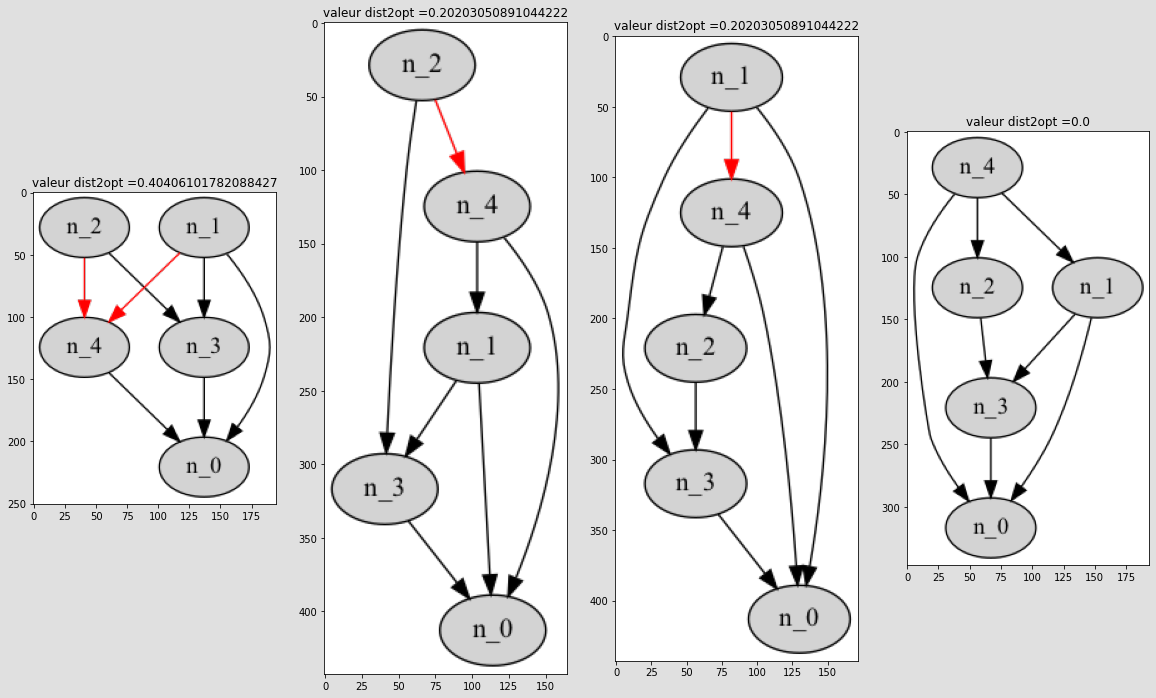

In [163]:
############Exemple############
bn=genRandomBN() #On génère un BN aléatoire
bn_approx,duration,_=learn_PC(bn,csvFilePath="test.csv",verbose=True) #On calcule des approximations de son squelette
visualise_difference(bn,bn_approx) #On regarde les différences entre les approximations et le bn original

## 1.2 Analyse Expérimentale de PC

### 1.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

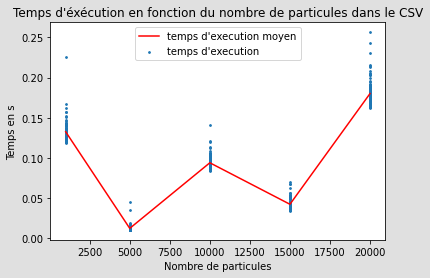

In [9]:

plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC))

### 1.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

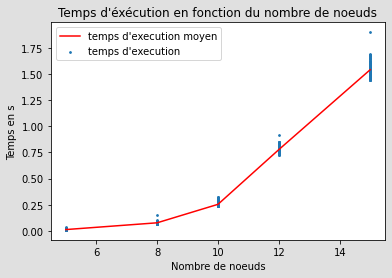

In [41]:

plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC))

### 1.2.3 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

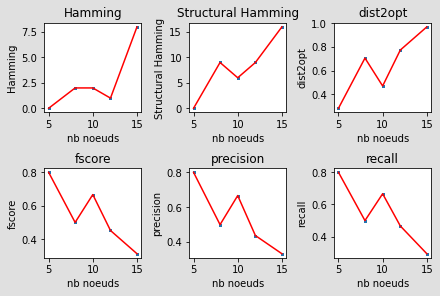

In [14]:

plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC))

### 1.2.4 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

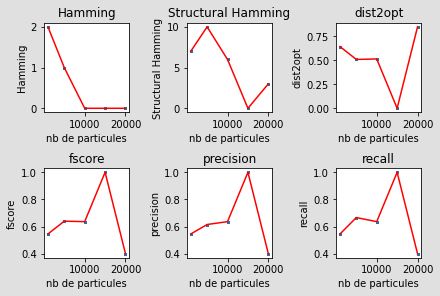

In [15]:

plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC))

## 1.3 Discussion
- On peut voir qu'en général plus le nombre de noeuds augmente, plus la qualité de la structure générée se déteriore sur tous les critères de comparaison.
- On peut voir qu'en général plus le nombre de particules augmente, plus la qualité de la structure générée s'améliore sur tous les critères de comparaison jusqu'à un certain nombre de particules à partir duquel la solution se déteriore.

- Il semblerait que si il n'y a pas assez ou trop de particules, la structure générée soit moins bonne. On peut voir par exemple ici (1.2.4) que les solutions s'améliorent jusqu'à un nombre de particule avoisinnant les 15000 puis se déteriore en augmentant le nombre de particules.

# 2. Algorithme PC-Stable

In [5]:
def learn_PC_STABLE(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime la structure d'un BN à partir de particules données à travers un CSV donné avec l'algorithme PC-Stable

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False
    isTest : bool, optional
        Indique si on est en l'execution est un test (dans ce cas là, on renvoi un seul des BN issus du graphe essentiels pour le tester, c'est un gain de temps car on ne génére pas les autres BN issus du graphe essentiel)
    nivRique : float, optional
        C'est le niveau de risque associé au calcul des indépendances
    Returns
    -------
    pyAgrum.BayesNet
        L'/Les approximation(s) du BN qui a généré les particules
    float
        la durée de calcul
    PC
        l'objet associé au calcul
    """
    start=time.time()#Enregister la durée de calcul
    Algo_PC_STABLE=PC(csvFilePath=csvFilePath)#Initialisation
    if verbose:
        print("######################## Apprentissage avec PC-STABLE ########################\n")
        GNonOriente=gum.MixedGraph(Algo_PC_STABLE.G)

    Algo_PC_STABLE.phase1_STABLE(nivRisque=nivRisque) #Phase 1
    if verbose:
        GPhase1=gum.MixedGraph(Algo_PC_STABLE.G)
    Algo_PC_STABLE.phase2() #Phase 2
    end=time.time()
    duration=end-start

    #Générer le/les BN issus du graphe essentiel
    if (not isTest):
        all_bnApprox=get_approxBN(bn,Algo_PC_STABLE)
    if (isTest):
        oneBN=getOneApproxBN(bn,Algo_PC_STABLE)

    #Affichage
    if verbose:
        GPhase21=Algo_PC_STABLE.GPhase21
        GPhase2=gum.MixedGraph(Algo_PC_STABLE.G)
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {Algo_PC_STABLE.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2")
        gnb.sideBySide(GNonOriente,GPhase1,GPhase21,GPhase2)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,Algo_PC_STABLE
    if (isTest):
        return oneBN,duration,Algo_PC_STABLE

## 2.1 Exemple d'utilisation

######################## Apprentissage avec PC-STABLE ########################

Apprentissage en 0.03532075881958008 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 8 arcs et de modalité maximum 3 
Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2.1 ------ Graphe 4 : après phase 2.2


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 3 --> 3 3 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->4 --> 1->4 <!-- 2->1 --> 2->1 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->1 --> 3->1 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->4 --> 1->4 <!-- 2->1 --> 2->1 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->1 --> 3->1 <!-- 3->4 --> 3->4


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC


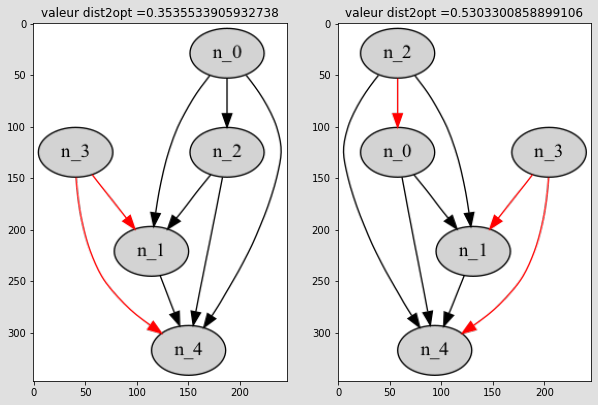

In [165]:
bn=genRandomBN()
bn_approx,duration,_=learn_PC_STABLE(bn,csvFilePath="test.csv",verbose=True,isTest=False)
visualise_difference(bn,bn_approx) #On regarde les différences entre les approximations et le bn original

## 2.2 Analyse Expérimentale de PC-Stable

### 2.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

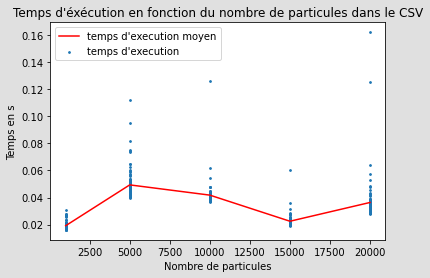

In [52]:
plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC_STABLE))

### 2.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

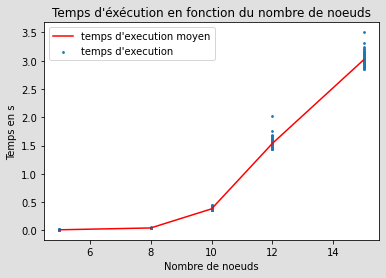

In [54]:
plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC_STABLE))

### 2.2.3 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

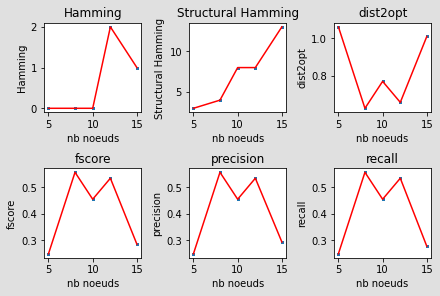

In [16]:
plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC_STABLE))

### 2.2.4 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

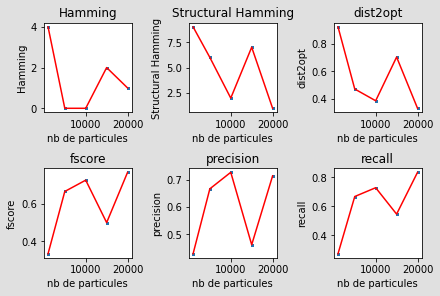

In [17]:
plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC_STABLE))

## 2.3 Discussion
### Pour PC-stable :
- En fonction du nombre de noeuds : Ce n'est pas aussi clair qu'avec PC mais il semble qu'en général plus le nombre de noeuds augmente, plus la qualité de la structure générée se déteriore sur tous les critères de comparaison.

- En fonction du nombre de particules : Il semble qu'en général plus le nombre de particules augmente, plus la qualité de la structure générée s'améliore sur tous les critères de comparaison.

### Comparaison entre PC et PC-stable : 
- On voit tout d'abord que PC-stable est plus rapide que PC (on le voit notamment en fonction du nombre de noeuds).

- En fonction du nombre de noeuds : PC-stable a de meilleurs résultats que PC en général sur les critères de la distance de Hamming (maximum atteinte avec PC était de 7.5 contre 2 avec PC-stable), de Structural Hamming (maximum atteinte avec PC était supérieur à 15 contre inférieur à 15 avec PC-stable), et de dist2opt (ne va pas en dessous de 0.6 avec PC-stable alors qu'il pouvait atteindre 0.3 avec PC). PC Stable est plus resistant à l'augmentation du nombre de noeuds.
- En ce qui concerne les critères F-score, precision et recall, on voit que la fenêtre de valeur de ces critères avec PC-stable est moins large qu'avec PC (tout comme avec les 3 premiers critères d'ailleurs).

- En fonction du nombre de particules : Pour PC-stable, tous les critères semblent être dans un intervalle de valeur beaucoup plus restreint qu'avec PC.
PC semble être plus performant mais les performances sur les critères sont moins stables qu'avec PC-Stable

### 2.3.1 Graphes réunis
#### 2.3.1.1 temps d'exécutions

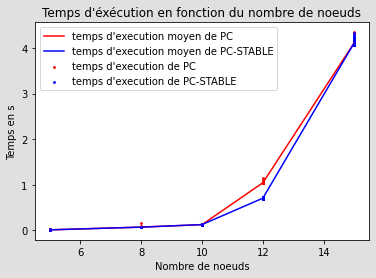

In [6]:

plot_testTempsExec_enFonction_nbNoeuds_bis(*testTempsExec_enFonction_nbNoeuds_2(learn_PC,learn_PC_STABLE),"PC","PC-STABLE")

In [8]:
plot_testTempsExec_enFonction_nbNoeuds_bis(*testTempsExec_enFonction_nbNoeuds_2(learn_PC,learn_PC_STABLE),"PC","PC-STABLE")

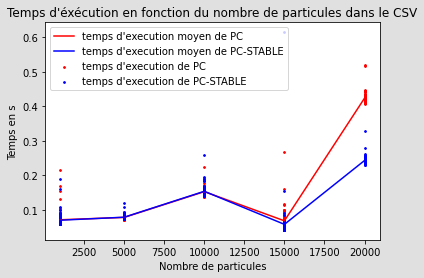

In [9]:

plot_testTempsExec_EnFonction_NbParticules2(*testTempsExec_EnFonction_NbParticules2(learn_PC,learn_PC_STABLE),"PC","PC-STABLE")

#### 2.3.1.2 Scores

Rouge = PC | Bleu = PC-STABLE


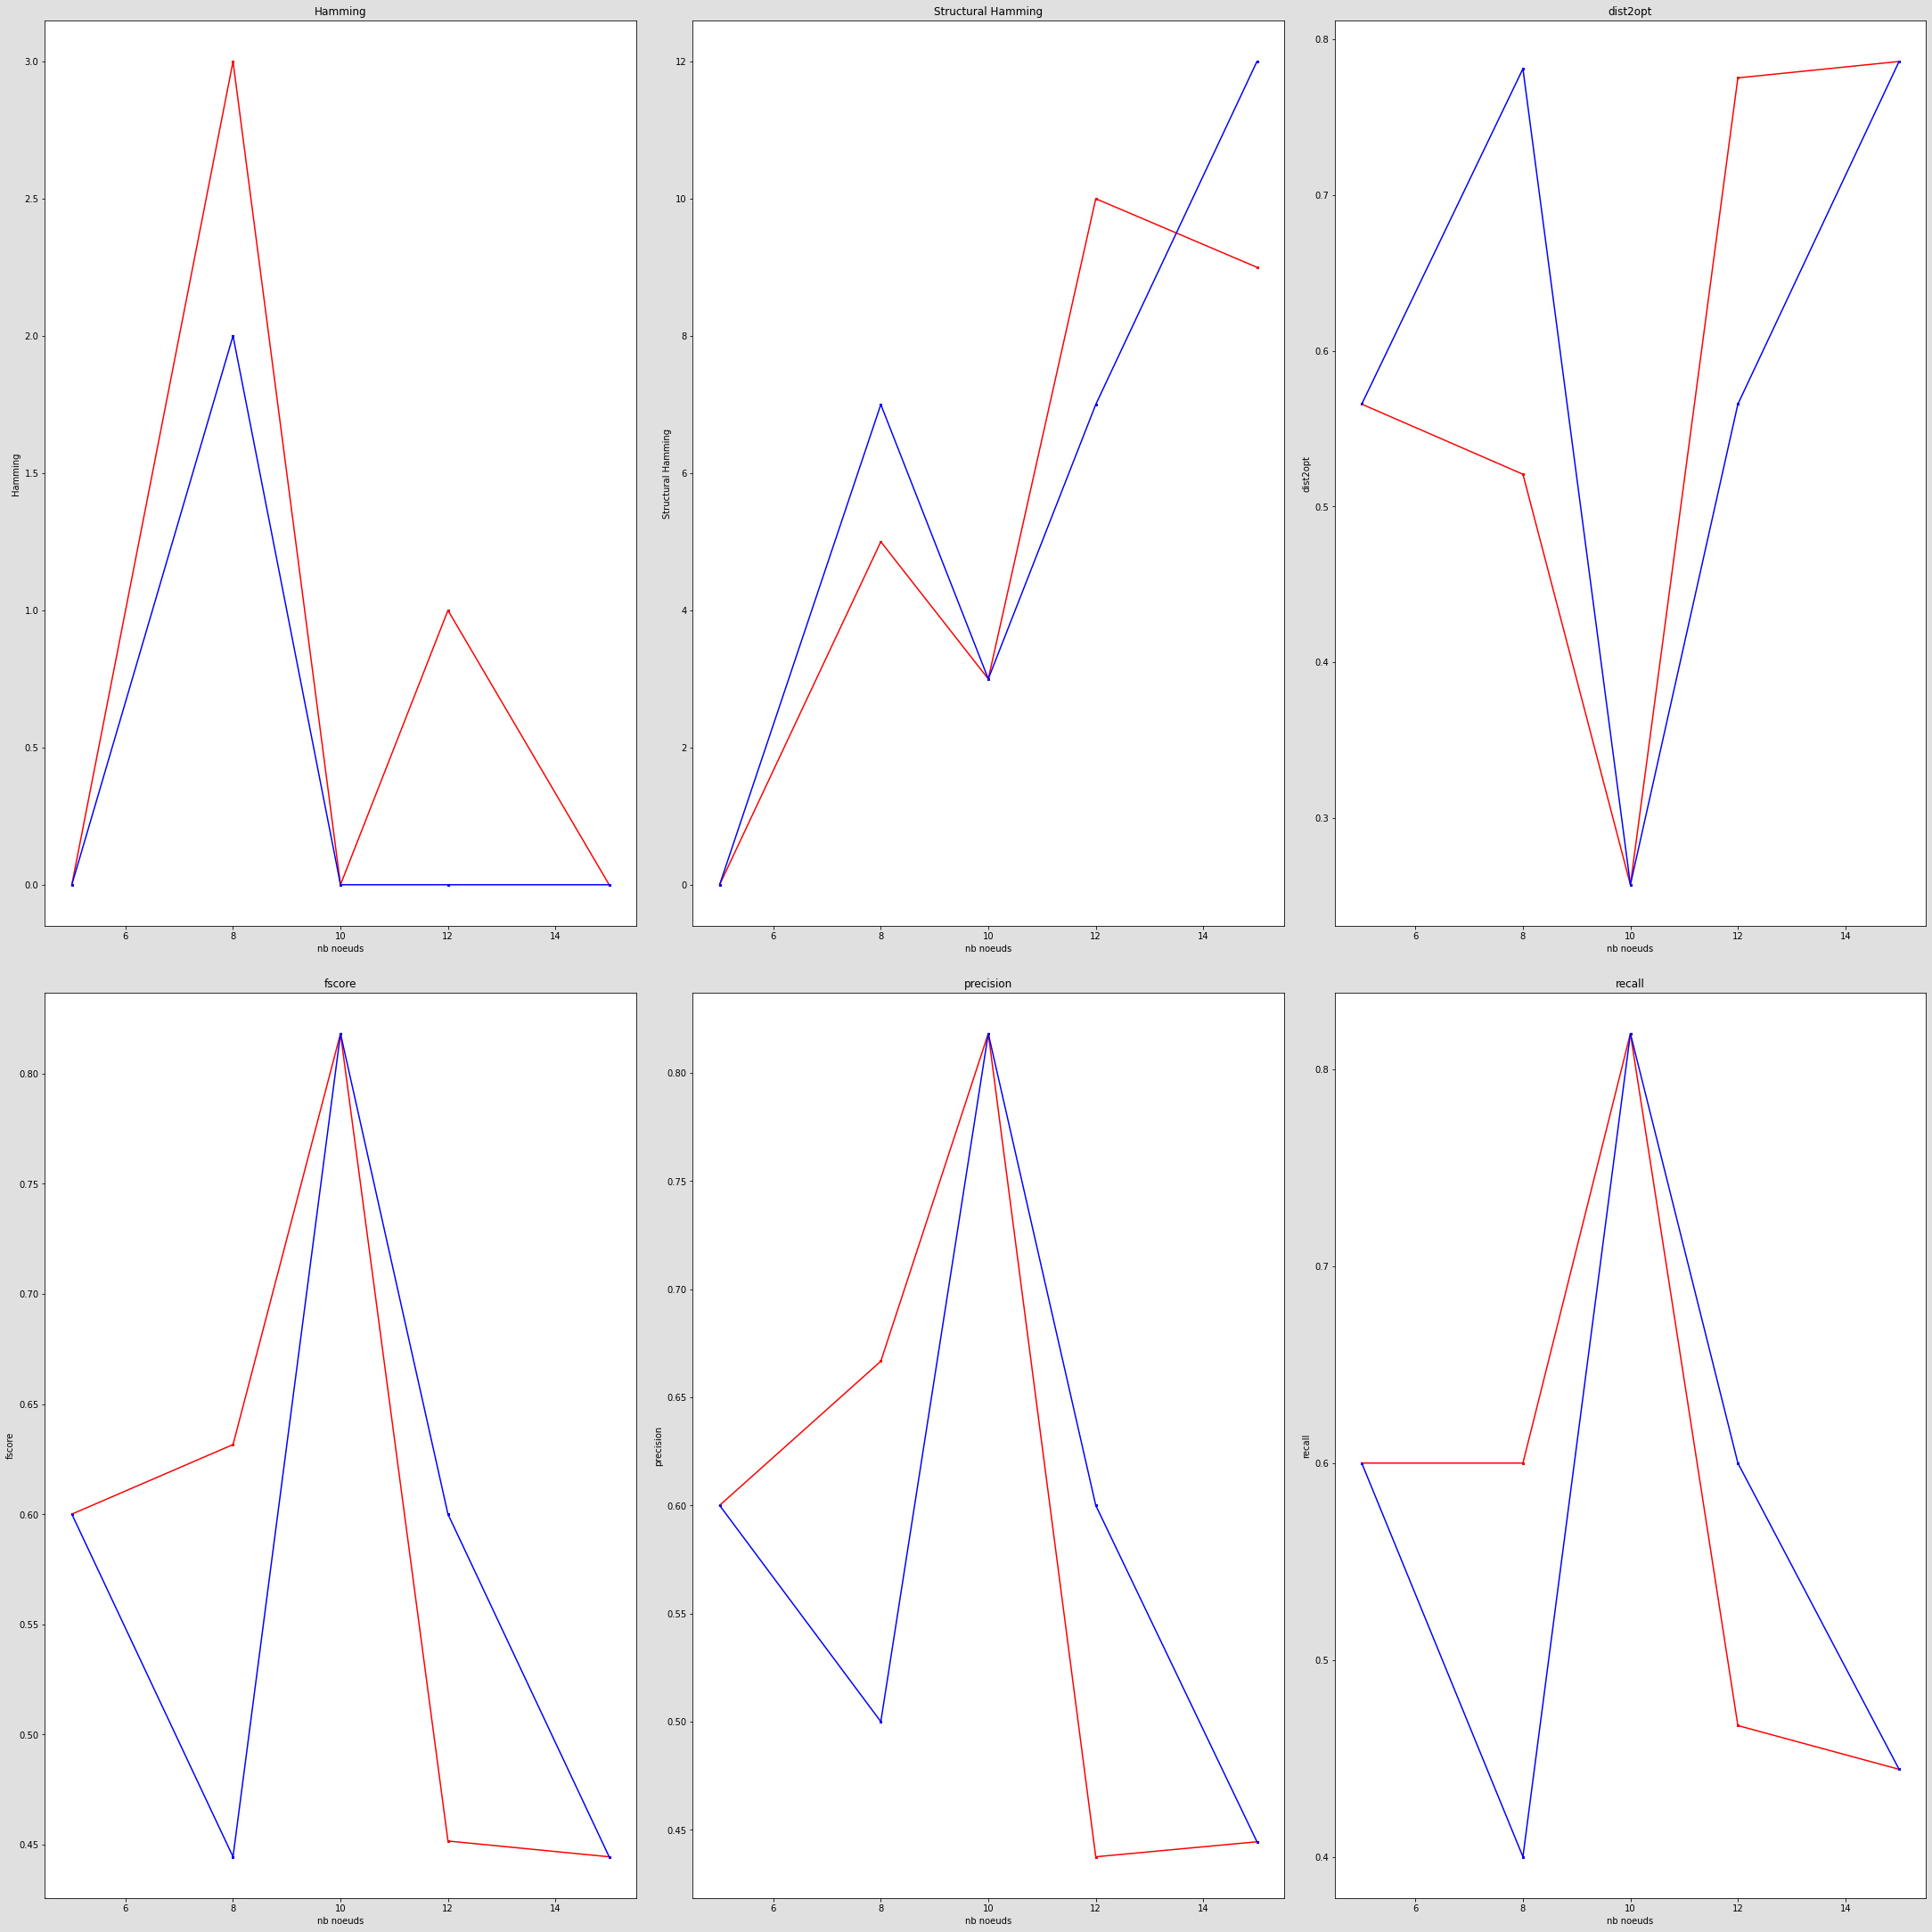

In [15]:

plot_tests_bn_vs_bn_enFontion_nbNoeud2(*tests_bn_vs_bn_enFontion_nbNoeud2(learn_PC,learn_PC_STABLE),"PC","PC-STABLE")

Rouge = PC | Bleu = PC-STABLE


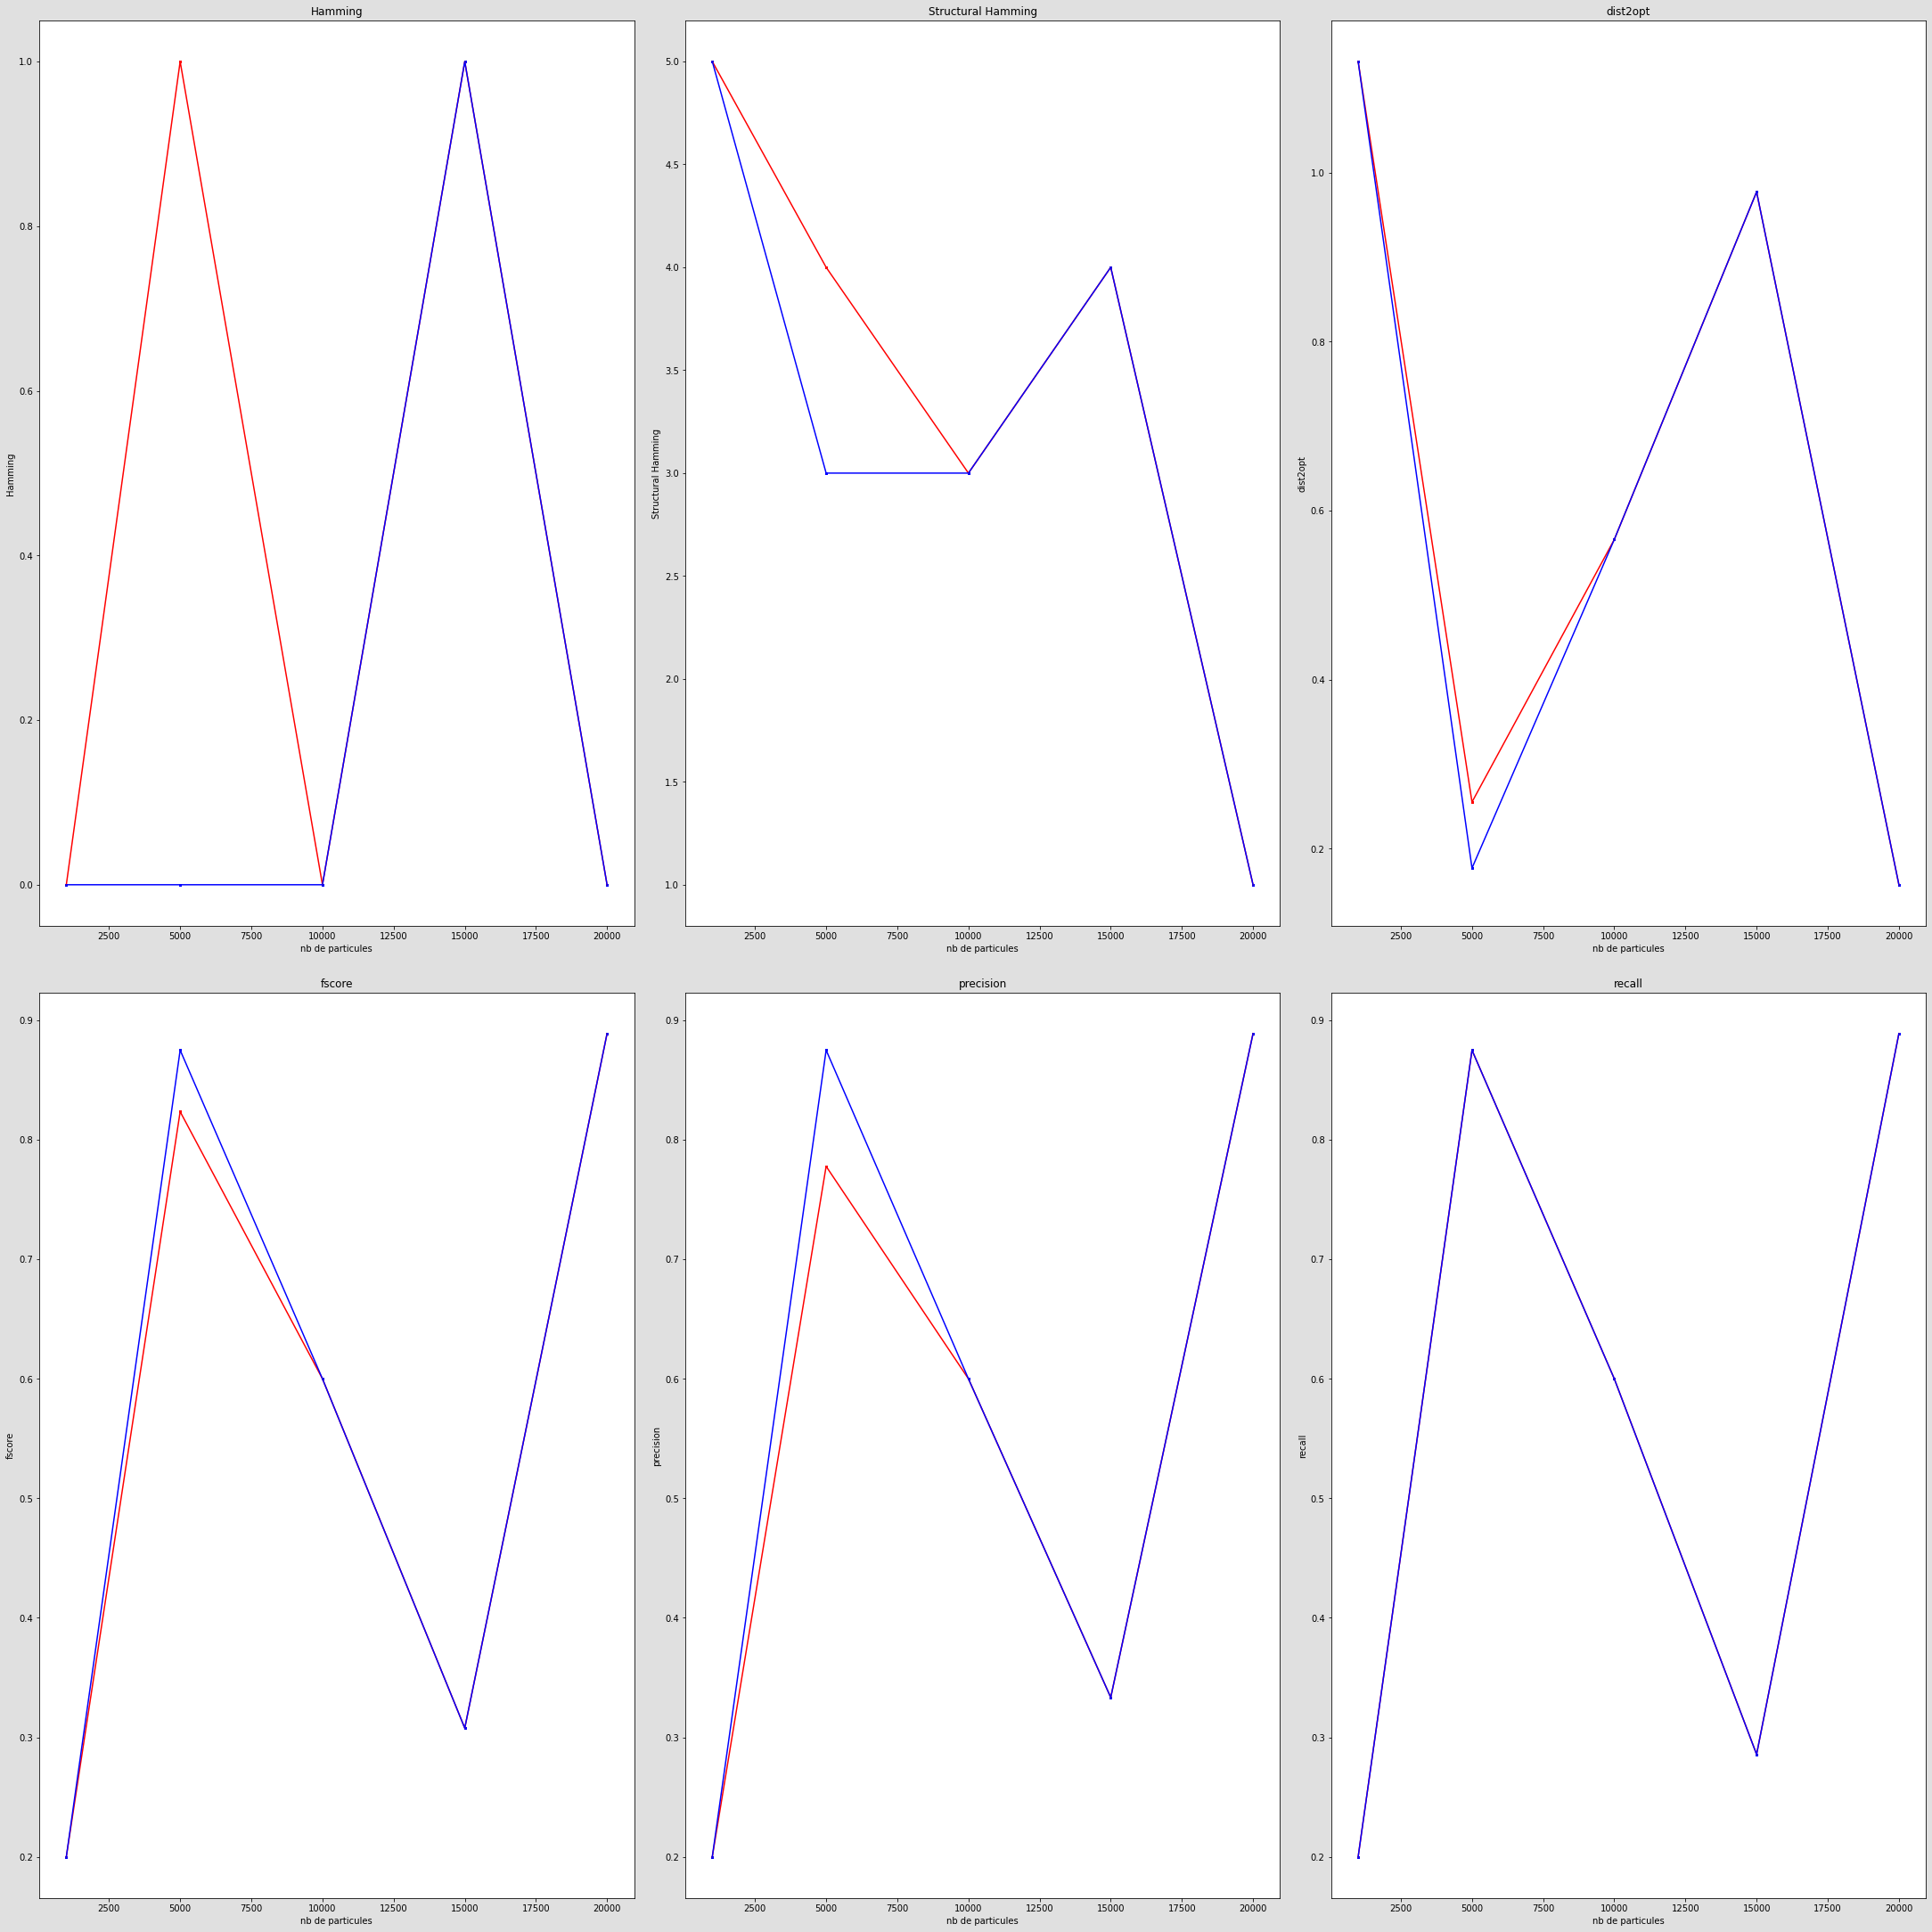

In [17]:
plot_tests_bn_vs_bn_enFontion_nbParticules2(*tests_bn_vs_bn_enFontion_nbParticules2(learn_PC,learn_PC_STABLE),"PC","PC-STABLE")

#### 2.3.1.2 Skeleton Scores

Rouge = PC | Bleu = PC-STABLE


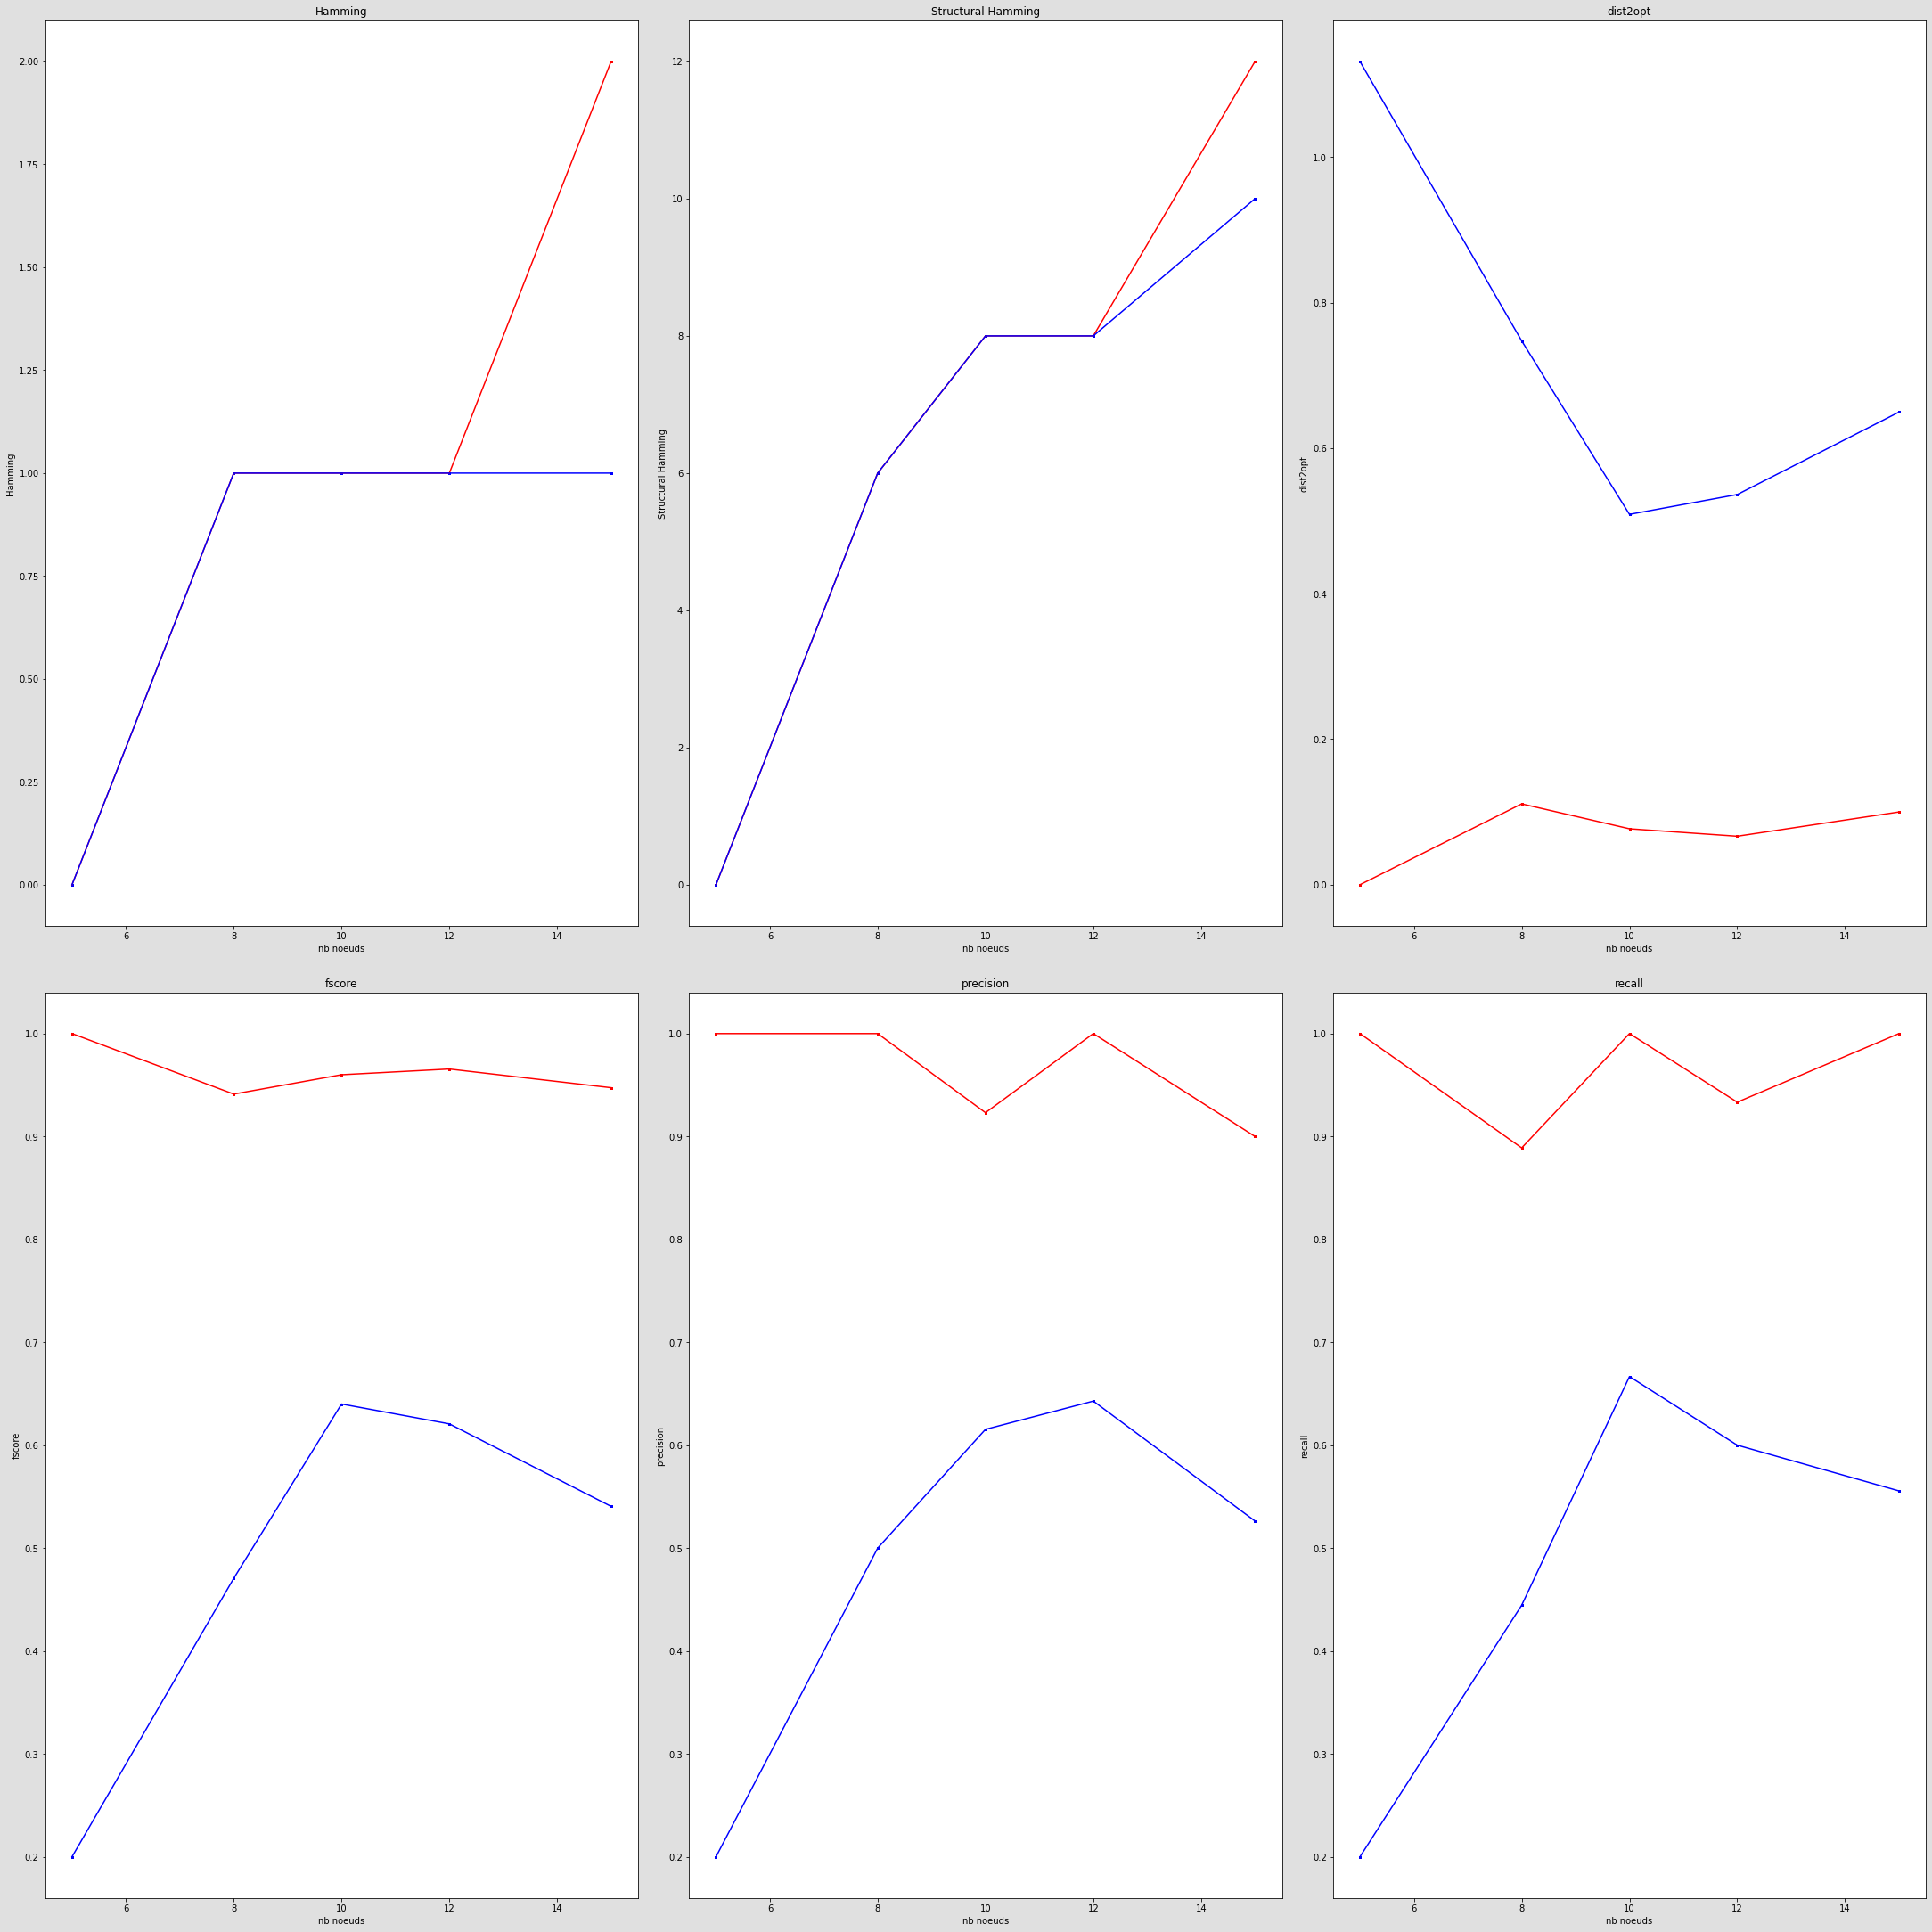

In [6]:
plot_tests_bn_vs_bn_enFontion_nbNoeud2(*tests_bn_vs_bn_enFontion_nbNoeud2(learn_PC,learn_PC_STABLE,isSkeleton=True),"PC","PC-STABLE")

Rouge = PC | Bleu = PC-STABLE


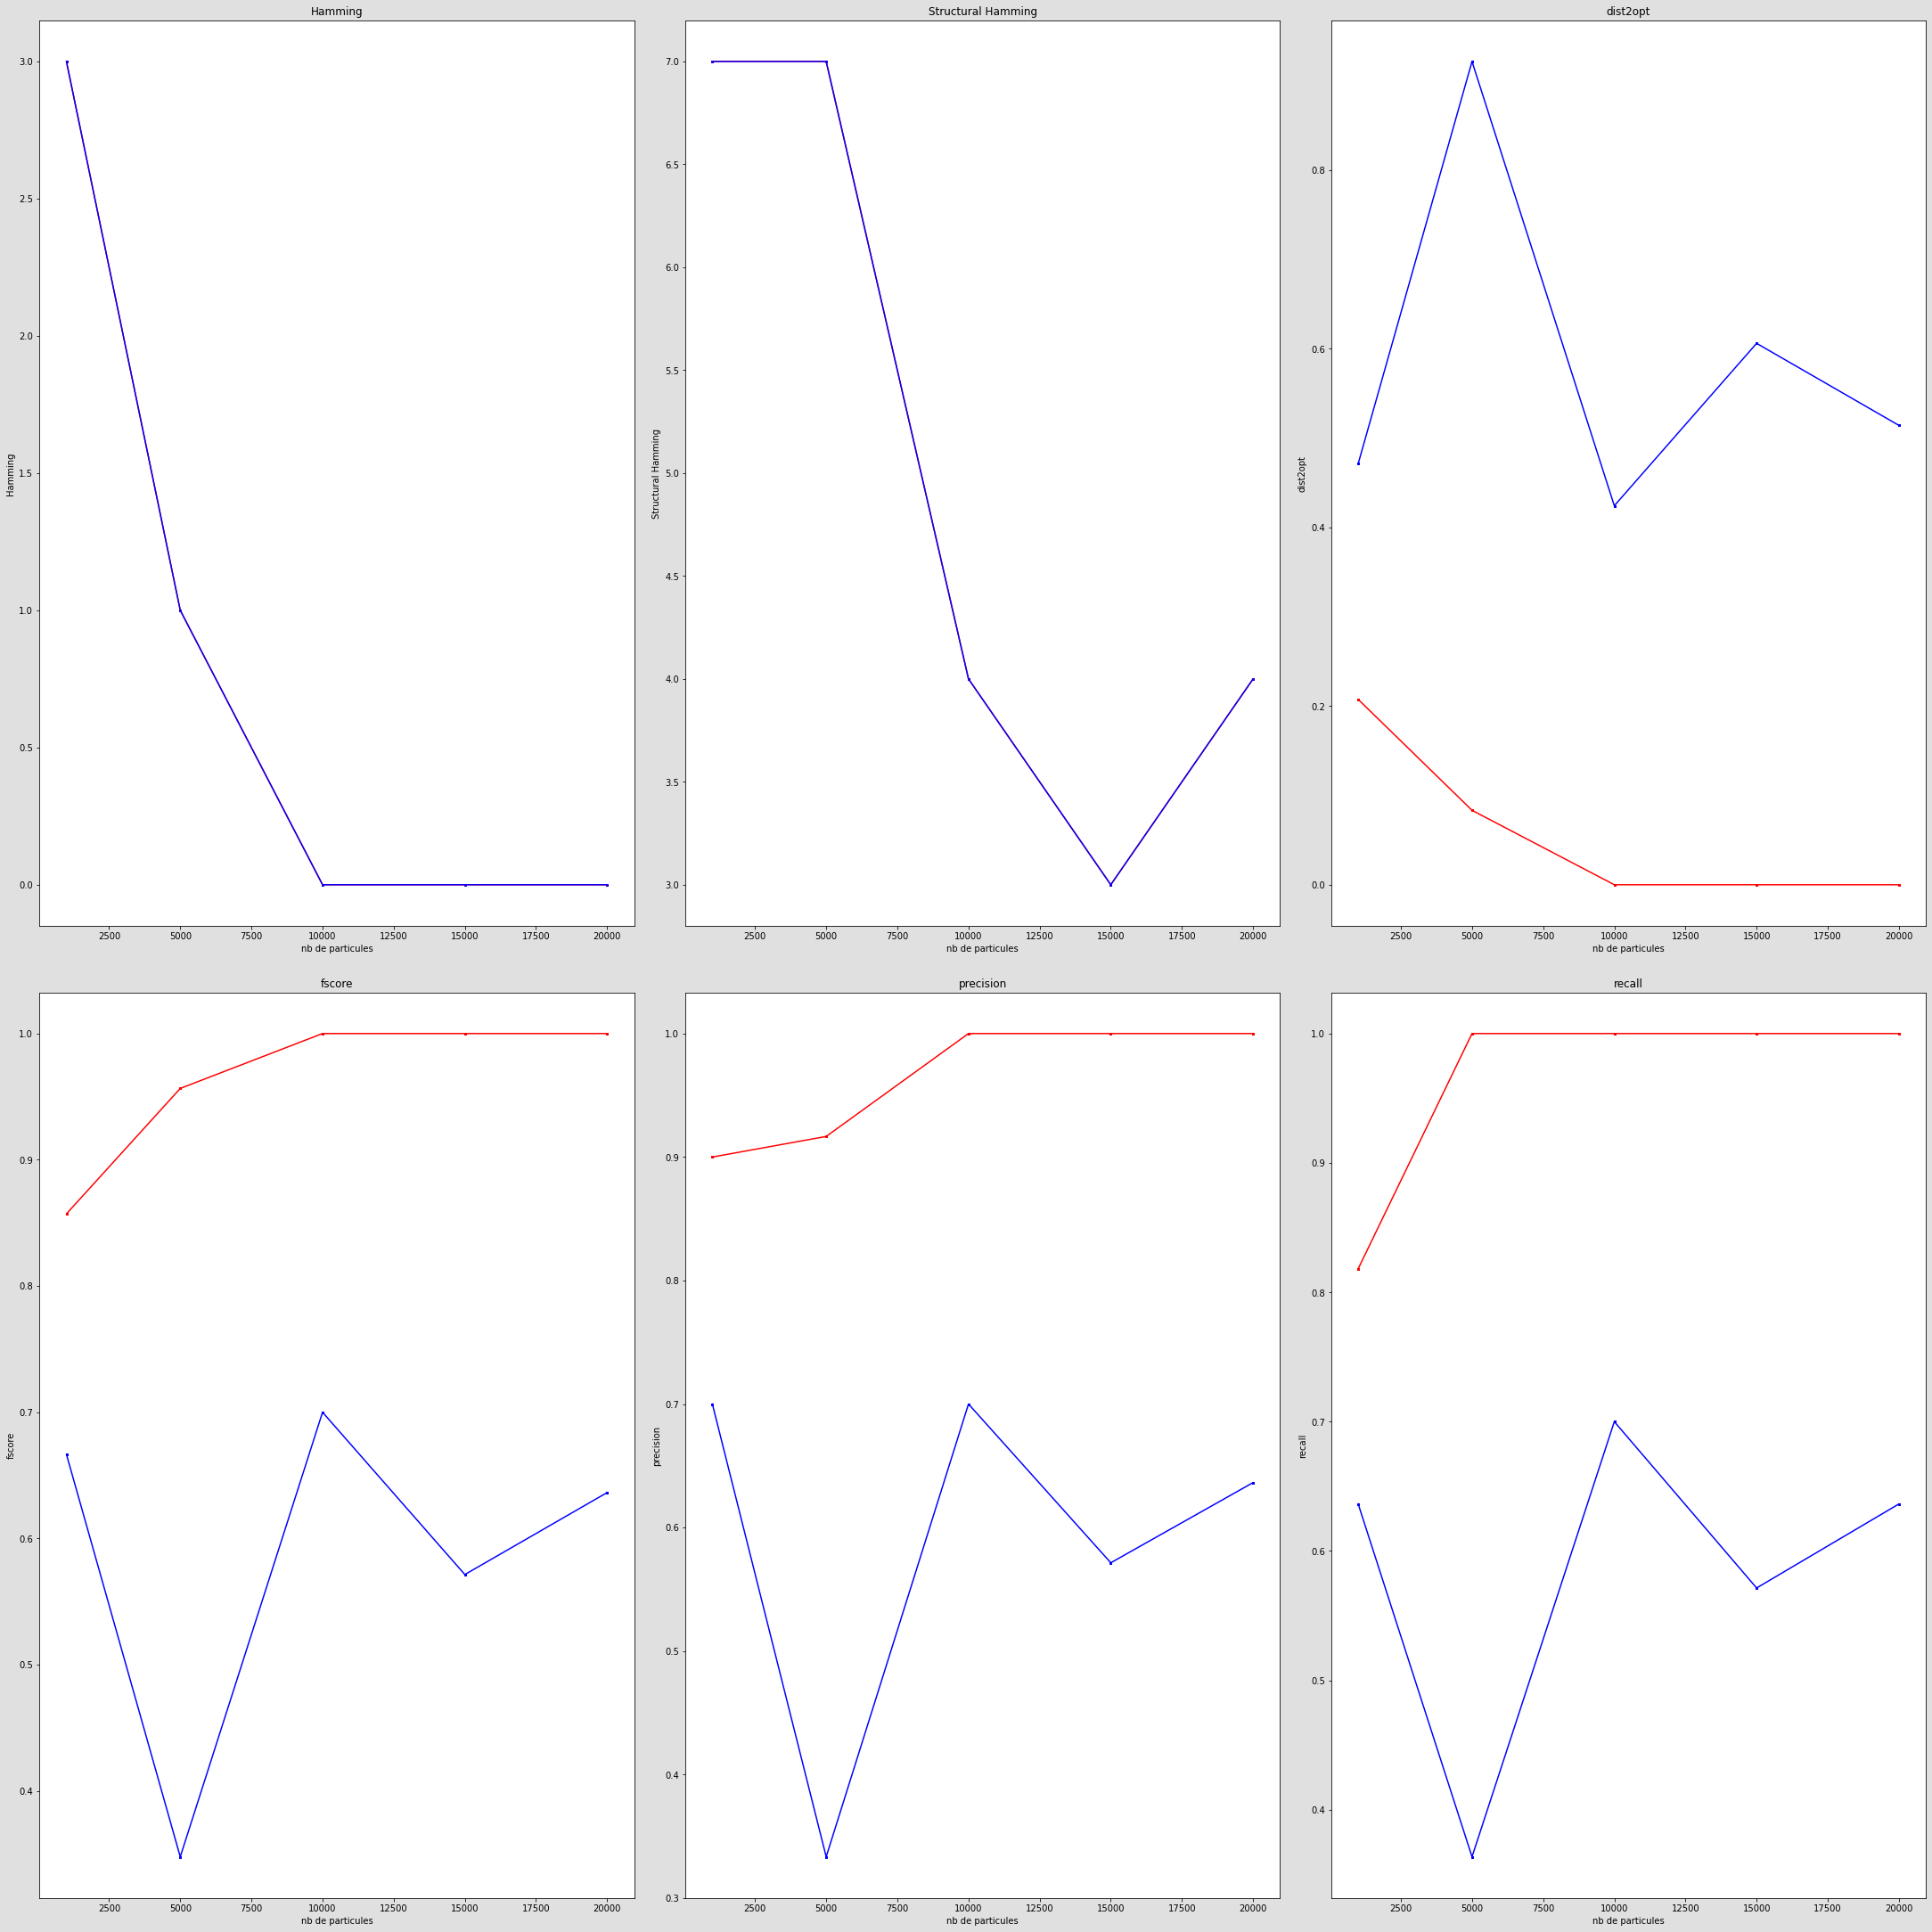

In [7]:
plot_tests_bn_vs_bn_enFontion_nbParticules2(*tests_bn_vs_bn_enFontion_nbParticules2(learn_PC,learn_PC_STABLE,isSkeleton=True),"PC","PC-STABLE")

# Bonus

## 3. PC-CSS VERSION 1 : Consistence de l'orientation

In [59]:

def learn_PC_CSS_Version1(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime la structure d'un BN à partir de particules données à travers un CSV donné avec l'algorithme PC-CSS Version Consistence de l'orientation

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False
    isTest : bool, optional
        Indique si on est en l'execution est un test (dans ce cas là, on renvoi un seul des BN issus du graphe essentiels pour le tester, c'est un gain de temps car on ne génére pas les autres BN issus du graphe essentiel)
    nivRique : float, optional
        C'est le niveau de risque associé au calcul des indépendances
    Returns
    -------
    pyAgrum.BayesNet
        L'/Les approximation(s) du BN qui a généré les particules
    float
        la durée de calcul
    PC
        l'objet associé au calcul
    """
    start=time.time()
    Algo_PC_CSS_Version1=PC(csvFilePath=csvFilePath) #Initialisation
    if verbose:
        print("######################## Apprentissage avec PC_CSS_Version 1 ########################\n")
        GNonOriente=gum.MixedGraph(Algo_PC_CSS_Version1.G)

    #On crée G2 un graphe sans arêtes avec les mêmes noeuds que le graphe complet
    G2=gum.MixedGraph()
    G2.addNodes(len(Algo_PC_CSS_Version1.learner.names()))

    #Phase 1
    Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=Algo_PC_CSS_Version1.G,G2=G2)
    G0=gum.MixedGraph(Algo_PC_CSS_Version1.G) #G0 est le graphe issus de NewStep1
    Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)
    if verbose:
        GPhase1=gum.MixedGraph(Algo_PC_CSS_Version1.G)
    allGs=[G0]#On enregistre tous les G_k
    DoesContinue=True
    k=0

    while(DoesContinue): #Boucle principale
        k+=1
        #Phase1+Phase2 = S_k
        Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=G0,G2=Gk_moins_1)
        Algo_PC_CSS_Version1.phase2()
        Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)#le nouveau G_{k-1}
        allGs.append(Gk_moins_1)
        #Condition d'arrêt
        for i in range(1,k):
            if(G_Equals(allGs[k-i],allGs[k])):
                DoesContinue=False
                break
        
    G_final=G_Union([allGs[g] for g in range(k-i,len(allGs))]) #Union de tous les G de k-i à k
    Algo_PC_CSS_Version1.G=G_final
    end=time.time()
    duration=end-start
    
    #Générer le/les BN issus du graphe essentiel
    if (not isTest):
        all_bnApprox=get_approxBN(bn,Algo_PC_CSS_Version1)
    if (isTest):
        oneBN=getOneApproxBN(bn,Algo_PC_CSS_Version1)
        
    #Affichage
    if verbose:
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {Algo_PC_CSS_Version1.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après premier NewPhase 1 ------ Graphe 3 : Après la boucle")
        gnb.sideBySide(GNonOriente,GPhase1,G_final)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC-CSS version 1")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,Algo_PC_CSS_Version1
    if (isTest):
        return oneBN,duration,Algo_PC_CSS_Version1

## 3.1 Exemple d'utilisation

######################## Apprentissage avec PC_CSS_Version 1 ########################

Apprentissage en 0.03948068618774414 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 5 arcs et de modalité maximum 4 
Graphe 1 : non orienté complet ------ Graphe 2 : après premier NewPhase 1 ------ Graphe 3 : Après la boucle


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 4 --> 4 4 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 1->2 --> 1->2 <!-- 3->1 --> 3->1 <!-- 3->2 --> 3->2 <!-- 4 --> 4 4 <!-- 4->1 --> 4->1 <!-- 4->2 --> 4->2


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC-CSS version 1


G <!-- n_2 --> n_2 n_2 <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_4->n_2 --> n_4->n_2 <!-- n_1 --> n_1 n_1 <!-- n_4->n_1 --> n_4->n_1 <!-- n_0 --> n_0 n_0 <!-- n_0->n_2 --> n_0->n_2 <!-- n_0->n_3 --> n_0->n_3 <!-- n_0->n_1 --> n_0->n_1


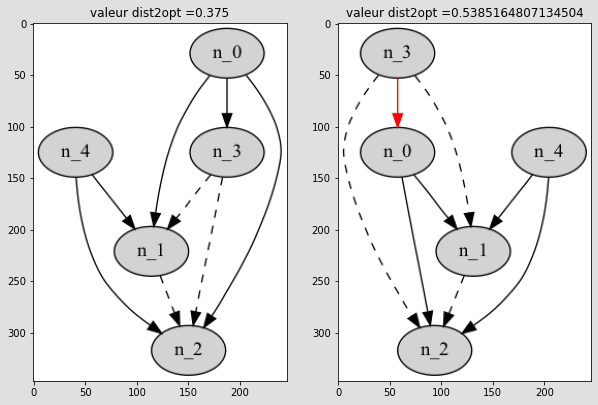

In [168]:
bn=genRandomBN()
bn_approx,duration,_=learn_PC_CSS_Version1(bn,csvFilePath="test.csv",verbose=True,isTest=False)
visualise_difference(bn,bn_approx) #On regarde les différences entre les approximations et le bn original

## 3.2 Analyse Expérimentale de PC-CSS Version 1 : Consistence de l'orientation

### 3.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

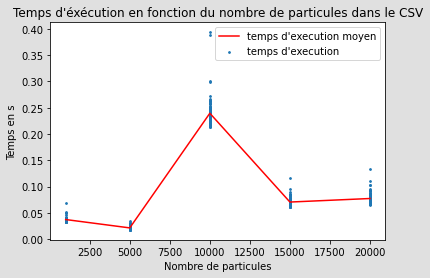

In [83]:
plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC_CSS_Version1))

### 3.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

In [ ]:
plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC_CSS_Version1))

### 3.2.3 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

In [ ]:
plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC_CSS_Version1))

### 2.2.4 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

In [ ]:
plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC_CSS_Version1))

## 4.PC-CSS VERSION 2 : Consistence du squelette

In [136]:
def learn_PC_CSS_Version2(bn,csvFilePath="test.csv",verbose=False,isTest=False,nivRisque=0.05):
    """Approxime la structure d'un BN à partir de particules données à travers un CSV donné avec l'algorithme PC-CSS Version Consistence du squelette

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour 
        générer les particules, by default False
    isTest : bool, optional
        Indique si on est en l'execution est un test (dans ce cas là, on renvoi un seul des BN issus du graphe essentiels pour le tester, c'est un gain de temps car on ne génére pas les autres BN issus du graphe essentiel)
    nivRique : float, optional
        C'est le niveau de risque associé au calcul des indépendances
    Returns
    -------
    pyAgrum.BayesNet
        L'/Les approximation(s) du BN qui a généré les particules
    float
        la durée de calcul
    PC
        l'objet associé au calcul
    """
    start=time.time()
    Algo_PC_CSS_Version1=PC(csvFilePath=csvFilePath)#initialisation

    if verbose:
        print("######################## Apprentissage avec PC_CSS_Version 2 ########################\n")

    GNonOriente=gum.MixedGraph(Algo_PC_CSS_Version1.G)#Le graphe complet pour faire la boucle avec les sepset
    G2=gum.MixedGraph()#on crée un graphe sans arêtes avec les mêmes noeuds que le graphe complet
    G2.addNodes(len(Algo_PC_CSS_Version1.learner.names()))
    Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=Algo_PC_CSS_Version1.G,G2=G2)#NewStep1
    G0=gum.MixedGraph(Algo_PC_CSS_Version1.G)#G0 prends la sortie de NewStep1
    sepSetK=[Algo_PC_CSS_Version1.sepSet.copy()]#On enregistre tous les sepsets de tous les graphes
    Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)

    if verbose:
        GPhase1=gum.MixedGraph(Algo_PC_CSS_Version1.G)

    allGs=[G0]#On enregistre tous les graphes
    DoesContinue=True
    k=0

    while(DoesContinue):#Boucle principale
        k+=1
        Algo_PC_CSS_Version1.phase1_PC_CSS(nivRisque=nivRisque,G1=G0,G2=Gk_moins_1)#New Step 1
        Gk_moins_1=gum.MixedGraph(Algo_PC_CSS_Version1.G)
        allGs.append(Gk_moins_1)
        sepSetK.append(Algo_PC_CSS_Version1.sepSet.copy())#On enregistre son sepset
        #Condition d'arrêt
        for i in range(1,k):
            if(G_Equals(allGs[k-i],allGs[k])):
                DoesContinue=False
                break

    G_final=G_Union([allGs[g] for g in range(k-i,len(allGs))]) #L'union de tous les G de k-i à k
    Algo_PC_CSS_Version1.G=G_final
    Algo_PC_CSS_Version1.phase2() #Orientation et propagation
    G_final=Algo_PC_CSS_Version1.G
    for x,y in GNonOriente.edges():#Boucle finale
        isPresent=False
        for a,b in G_final.edges().union(G_final.arcs()):
            if x==a and y==b or x==b and y==a:
                isPresent=True
                break
        if not isPresent:
            sepSetG_final=sepSetK[i]
            if(not sepSetG_final[(x,y)].issubset(Algo_PC_CSS_Version1.findConsistentSet(x,y,G_final)) and not sepSetG_final[(x,y)].issubset(Algo_PC_CSS_Version1.findConsistentSet(y,x,G_final))):
                G_final.addEdge(x,y)

    Algo_PC_CSS_Version1.G=G_final
    end=time.time()
    duration=end-start
    
    #Générer le/les BN associé au graphe essentiel
    if (not isTest):
        all_bnApprox=get_approxBN(bn,Algo_PC_CSS_Version1)
    if (isTest):
        oneBN=getOneApproxBN(bn,Algo_PC_CSS_Version1)
        
    #Affichage
    if verbose:
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {Algo_PC_CSS_Version1.learner.nbRows()} particules générées à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après premier NewPhase 1 ------ Graphe 3 : Après la boucle")
        gnb.sideBySide(GNonOriente,GPhase1,G_final)
        if(not isTest):
            print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC-CSS version 2")
            gnb.sideBySide(bn,*all_bnApprox)
        if (isTest):
            print("1er BN = BN utilisé pour générer les particules ------ 2ème BN = un des BN possibles issus du graphe essentiel")
            gnb.sideBySide(bn,oneBN)
    if (not isTest):
        return all_bnApprox,duration,Algo_PC_CSS_Version1
    if (isTest):
        return oneBN,duration,Algo_PC_CSS_Version1

## 4.1 Exemple d'utilisation

######################## Apprentissage avec PC_CSS_Version 2 ########################

Apprentissage en 0.0336461067199707 seconde avec 20000 particules générées à partir d'un BN avec 5 noeuds, 4 arcs et de modalité maximum 3 
Graphe 1 : non orienté complet ------ Graphe 2 : après premier NewPhase 1 ------ Graphe 3 : Après la boucle


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 2 --> 2 2 <!-- 1->2 --> 1->2 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 1->0 --> 1->0 <!-- 2 --> 2 2 <!-- 1->2 --> 1->2 <!-- 3 --> 3 3 <!-- 3->0 --> 3->0 <!-- 4 --> 4 4 <!-- 3->4 --> 3->4 <!-- 4->0 --> 4->0


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC-CSS version 2


G <!-- n_2 --> n_2 n_2 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1 <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_0->n_3 --> n_0->n_3 <!-- n_1->n_0 --> n_1->n_0,G <!-- n_2 --> n_2 n_2 <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_3->n_0 --> n_3->n_0 <!-- n_4->n_0 --> n_4->n_0 <!-- n_1 --> n_1 n_1 <!-- n_1->n_2 --> n_1->n_2 <!-- n_1->n_0 --> n_1->n_0,G <!-- n_2 --> n_2 n_2 <!-- n_3 --> n_3 n_3 <!-- n_0 --> n_0 n_0 <!-- n_3->n_0 --> n_3->n_0 <!-- n_4 --> n_4 n_4 <!-- n_4->n_3 --> n_4->n_3 <!-- n_4->n_0 --> n_4->n_0 <!-- n_1 --> n_1 n_1 <!-- n_1->n_2 --> n_1->n_2 <!-- n_1->n_0 --> n_1->n_0,G <!-- n_2 --> n_2 n_2 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1 <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_0 --> n_0 n_0 <!-- n_3->n_0 --> n_3->n_0 <!-- n_4->n_0 --> n_4->n_0 <!-- n_1->n_0 --> n_1->n_0,G <!-- n_2 --> n_2 n_2 <!-- n_1 --> n_1 n_1 <!-- n_2->n_1 --> n_2->n_1 <!-- n_3 --> n_3 n_3 <!-- n_0 --> n_0 n_0 <!-- n_3->n_0 --> n_3->n_0 <!-- n_4 --> n_4 n_4 <!-- n_4->n_3 --> n_4->n_3 <!-- n_4->n_0 --> n_4->n_0 <!-- n_1->n_0 --> n_1->n_0


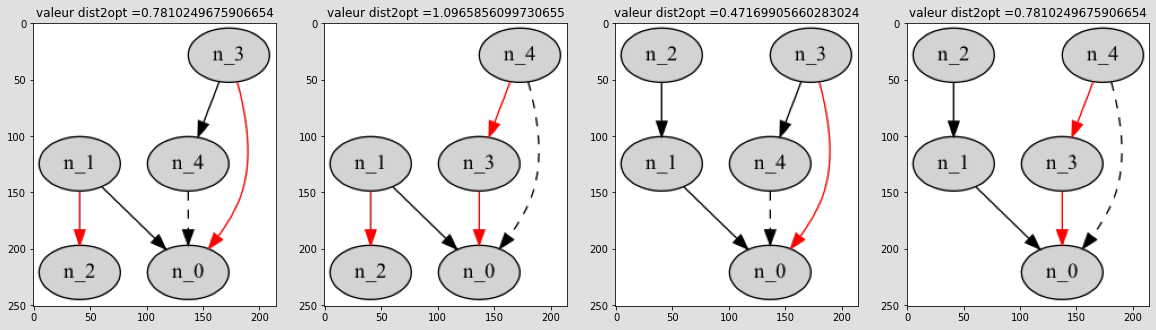

In [169]:
bn=genRandomBN()
bn_approx,duration,_=learn_PC_CSS_Version2(bn,csvFilePath="test.csv",verbose=True,isTest=False)
visualise_difference(bn,bn_approx) #On regarde les différences entre les approximations et le bn original

## 4.2 Analyse Expérimentale de PC-CSS - Version 2 : Consistence du squelette

### 4.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- n_nodes = entier entre 5 et 10
- n_arcs=1.25*n_nodes

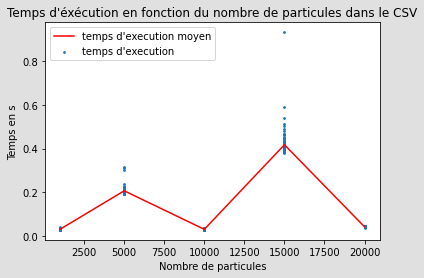

In [99]:
plot_testTempsExec_EnFonction_NbParticules(*testTempsExec_EnFonction_NbParticules(learn_PC_CSS_Version2))

### 4.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

In [ ]:
plot_testTempsExec_enFonction_nbNoeuds(*testTempsExec_enFonction_nbNoeuds(learn_PC_CSS_Version2))

### 4.2.3 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

In [ ]:
plot_tests_bn_vs_bn_enFontion_nbNoeud(*tests_bn_vs_bn_enFontion_nbNoeud(learn_PC_STABLE))

### 2.2.4 Test Structural Hamming, F-score, dist2opt, etc. en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

In [ ]:
plot_tests_bn_vs_bn_enFontion_nbParticules(*tests_bn_vs_bn_enFontion_nbParticules(learn_PC_STABLE))

## Discussion sur PC-CSS Version 1 et 2
- Pendant l'exécution des deux versions de PC-CSS, nous rencontrons souvent la création de cycles dans les approximations du BN.
- Il est donc assez difficile de lancer beaucoup d'exécutions successives sans lever une exception.
- De ce fait, nous n'avons pas pu tester complètement les deux implémentations.


- Nous pensons que c'est dû à :
    - la transformation de certains arcs en arêtes pendant l'étape d'union des BNs. En effet, certains de ces arcs ont étés dirigé pour empêcher l'apparition de cycles dans certains BN. 
--> Ces nouvelles arêtes seront ensuite dirigées quand nous allons transformer le graphe essentiel vers les différents BNs possibles, ce qui peut créer des cycles.
 

# Conclusion


Nous avons implémenté PC, PC-STABLE et les deux versions de PC-CSS.

Nous avons pu constater que :

- Les performances de PC-STABLE sont plus stables que ceux de PC : les performances varient moins, les intervalles sur les graphes de performances sont généralement plus petits
- PC-CSS présente un problème de création de cycle pendant l'étape d'union des différents BN crées pendant les itérations
- PC et PC-STABLE permettent d'obtenir un ou plusieurs BN qui ont plus ou moins la même structure que le BN original : les erreurs étaient surtout des arêtes mal orientées, l'algorithme ne rajoute (respectivement enlève) que très peu d'arcs qui étaient absents (respectivement présents) du BN original.

Perspectives d'amélioration :
- Il faudrait écrire une fonction d'agrégation des performances des approximations du BN qui permet de choisir automatiquement celui qui le décrit le mieux. En effet, nous avons seulement considéré dans notre projet le critère dist2opt dans notre choix de la meilleure approximation
- Dans PC-CSS, il faudrait revoir l'union : peut-être faut-il donner la priorité à l'orientation des arcs du BN lors d'un conflit de type arc et arête (--> et -- ou <-- et --) et ne rajouter une arête que s'il y a un conflit de type arc et arc (--> et <-- ou --> et <--). En effet, en donnant la priorité à l'orientation, si cette orientation avait été ajoutée pour empêcher un cycle, on aura plus de chance d'éviter la création de cycles. Notre raisonnement est le suivant : considéront 3 noeuds $x_0,x_1,x_2$ tels que $x_0$->$x_1$, $x_2$->$x_1$ et $x_2$->$x_0$ (Graphe 1). S'il y a un conflit de type arc et arêtes sur l'arc $x_2$->$x_1$ (avec un BN tel que le graphe 2), on garderait l'orientation pour eviter la création du cycle $x_1$->$x_2$->$x_0$->$x_1$. Il reste pourtant une possibilité de création de cycle dans cette instance : c'est l'éventualité d'un conflit de type arc -> et arc <- sur l'arc $x_2$->$x_1$ (avec un BN tel que le graphe 3) qui forcerait que l'on enlève l'orientation, ce qui mènerait forcément à un cycle.

In [173]:
graphe1=gum.MixedGraph()
graphe1.addNodes(3)
for i,j in [(1,2),(3,2),(3,1)]:
    graphe1.addArc(i-1,j-1)
graphe2=gum.MixedGraph()
graphe2.addNodes(3)
for i,j in [(1,2),(3,1)]:
    graphe2.addArc(i-1,j-1)
graphe2.addEdge(3-1,2-1)
graphe3=gum.MixedGraph()
graphe3.addNodes(3)
for i,j in [(1,2),(2,3),(1,3)]:
    graphe3.addArc(i-1,j-1)
print("Graphe 1, 2 et 3")
gnb.sideBySide(graphe1,graphe2,graphe3)

Graphe 1, 2 et 3


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 2->0 --> 2->0 <!-- 2->1 --> 2->1,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 1->2 --> 1->2 <!-- 2->0 --> 2->0,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 1->2 --> 1->2


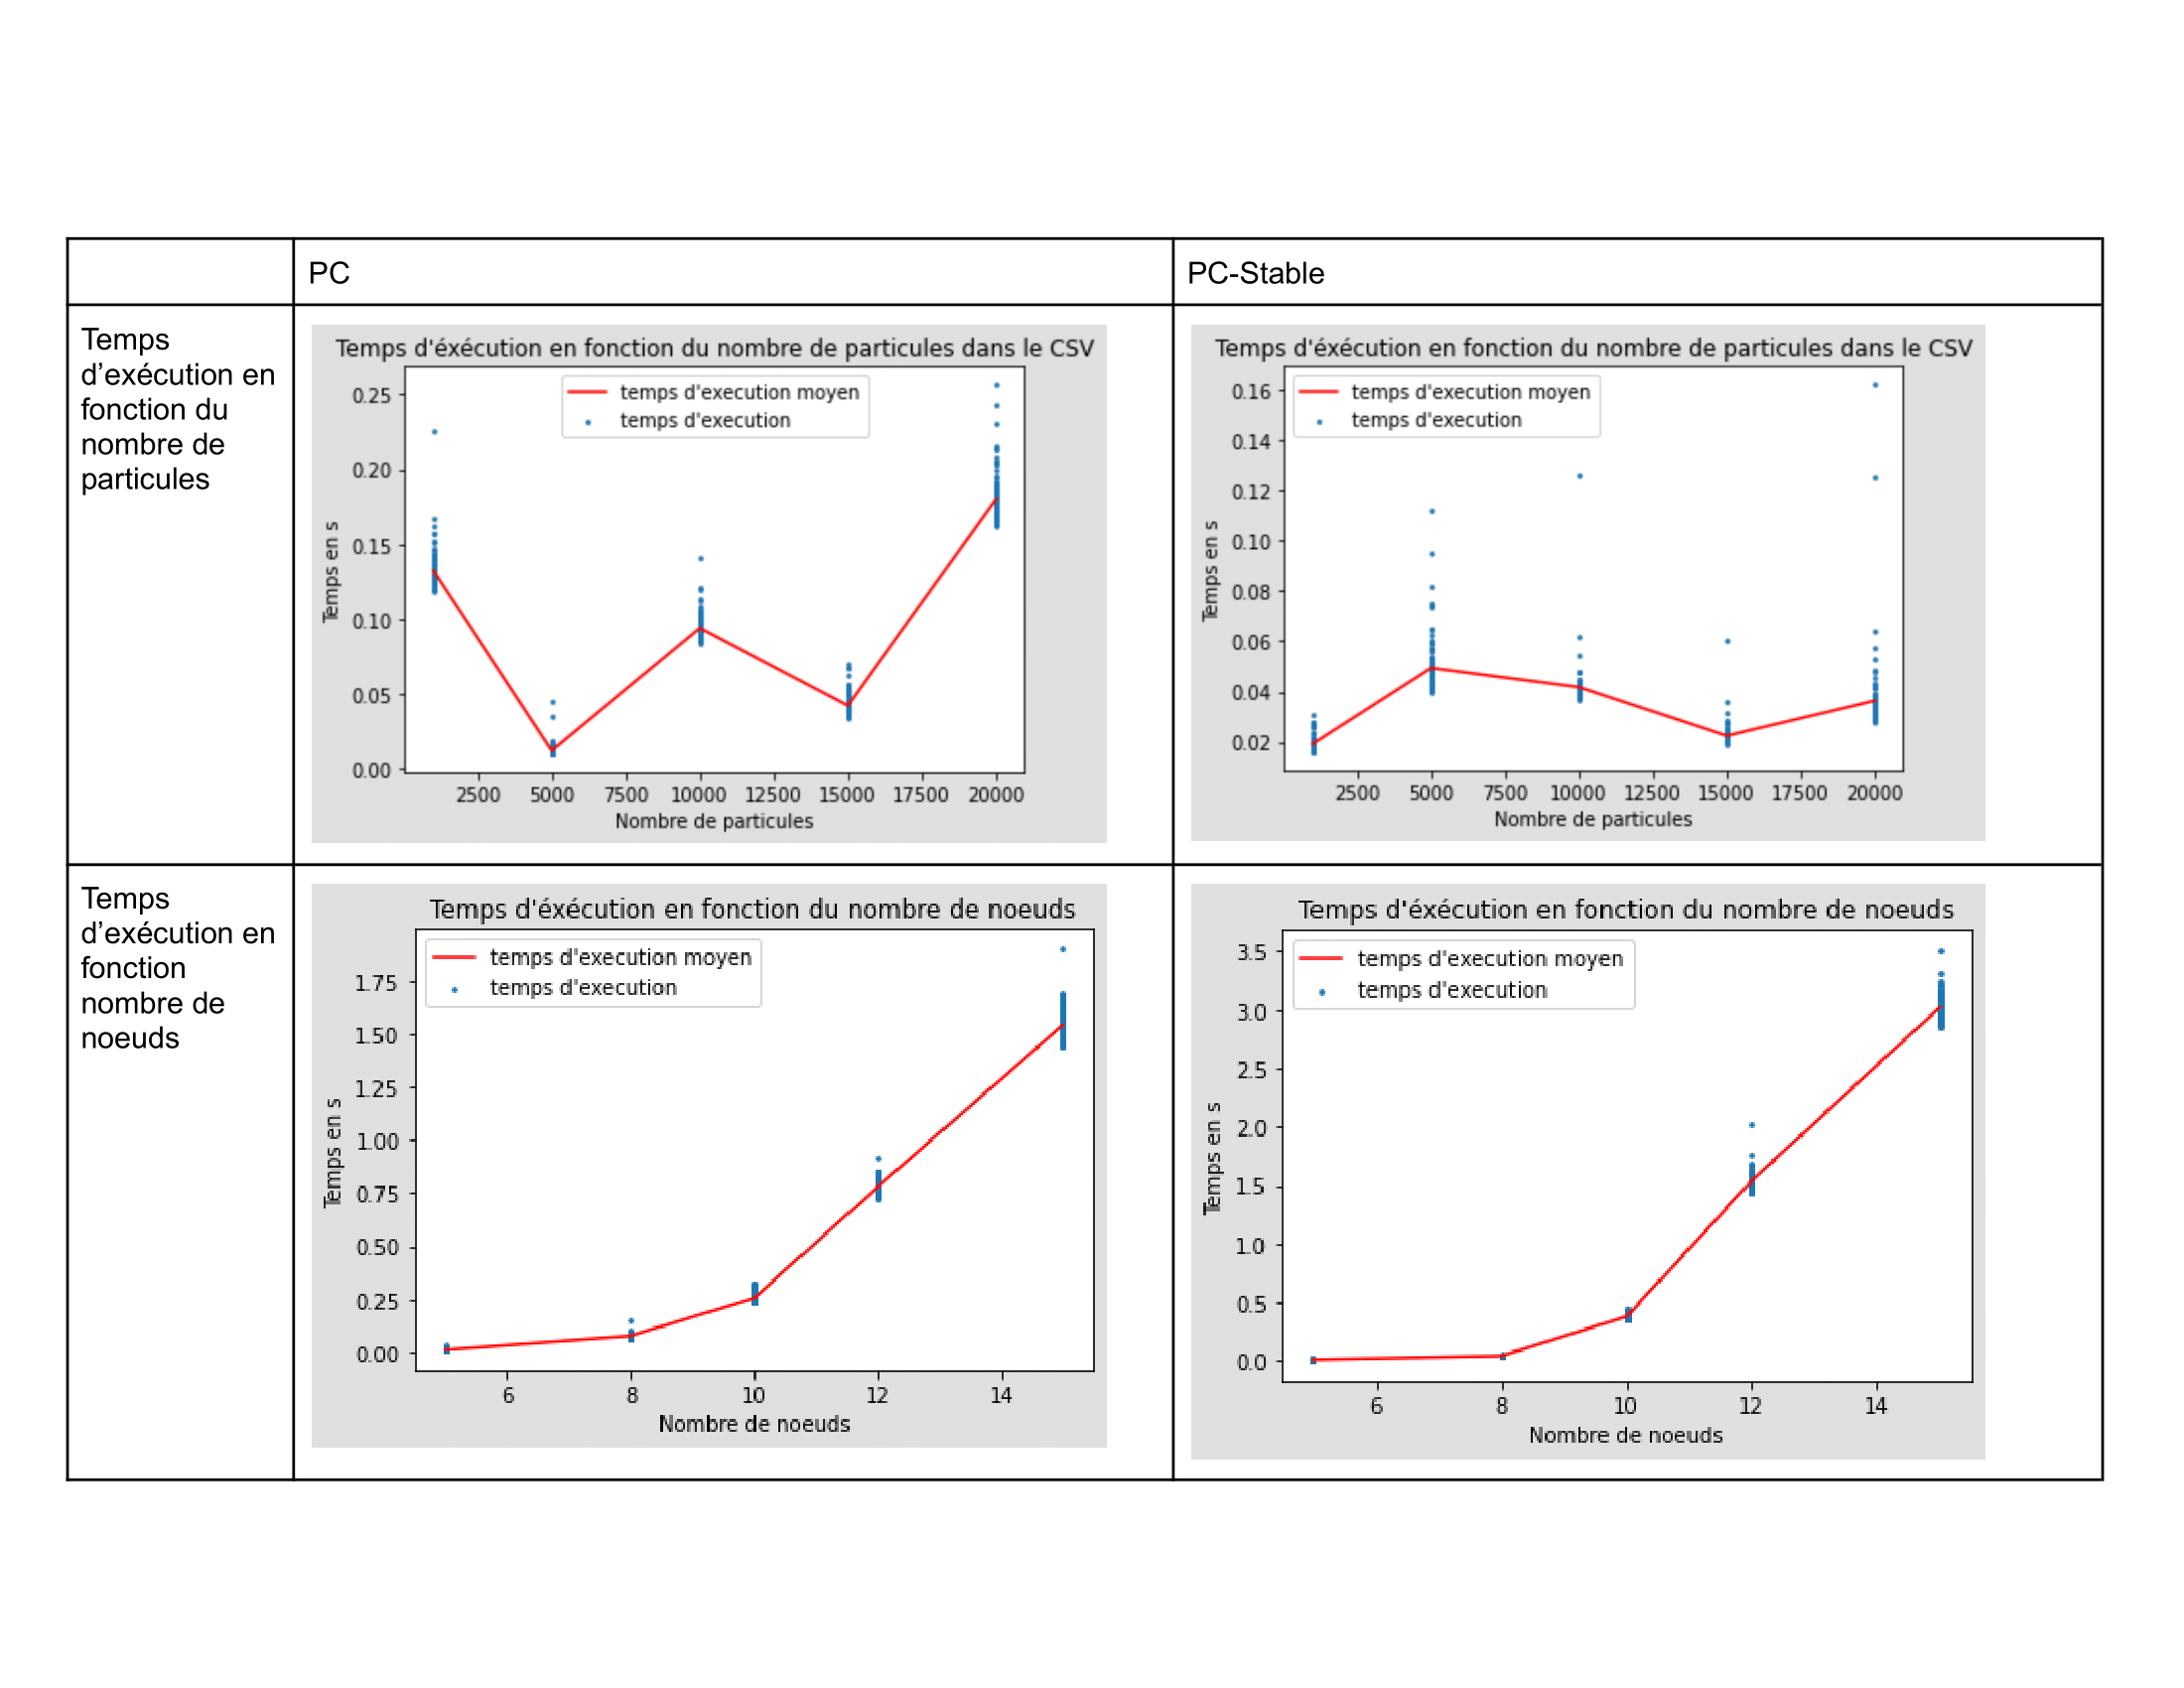

In [4]:
from IPython.display import Image
Image(filename='/Users/davidpinaud/Desktop/Untitled document/Untitled document-1.png')


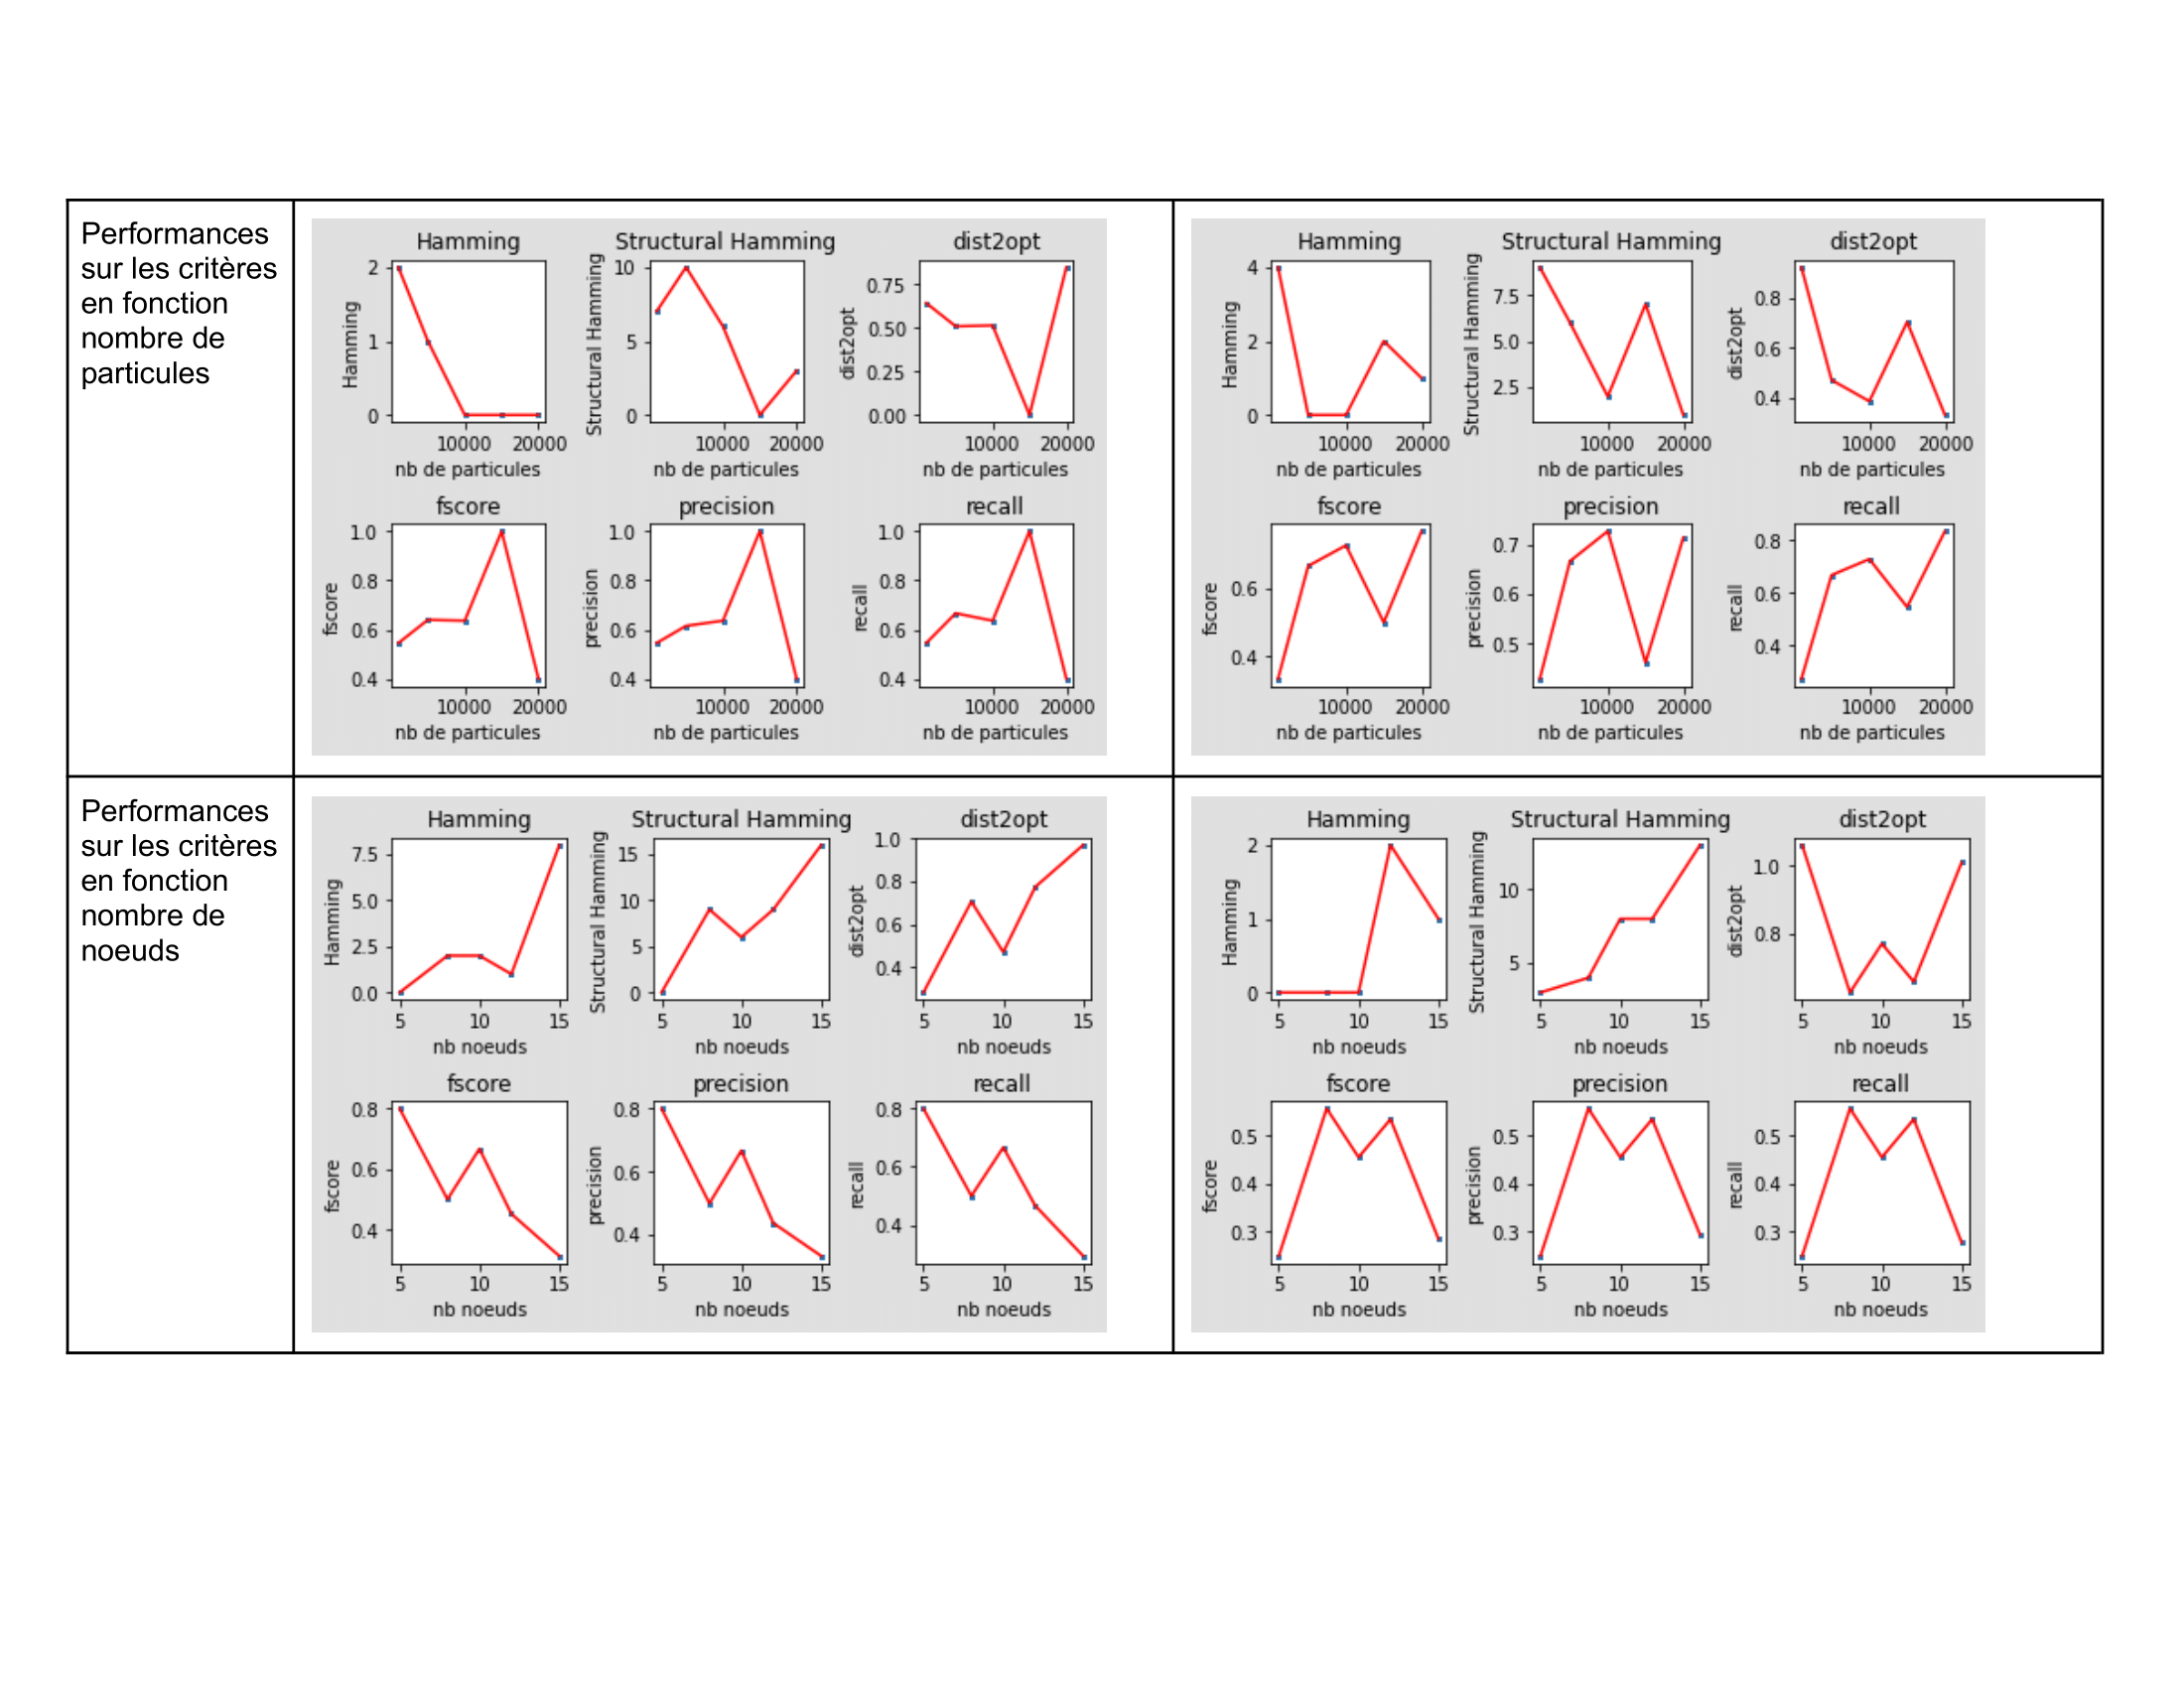

In [3]:
Image(filename='/Users/davidpinaud/Desktop/Untitled document/Untitled document-2.png')